# Imports

In [2]:
import pypsa
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import xarray as xr
import statsmodels.api as sm
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import matplotlib.ticker as ticker
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from pyproj import Geod
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite_granularity_total, region_area
from interconnectors import efficiency_link, calculate_distance

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# User input

In [3]:
# Parameter selection input 
scenario_year = 2050
era_year = 2023
density = {}
density['wind'] = 10 # W/m2
density['pv'] = 45 # W/m2
land_use_availability = {}
land_use_availability['wind'] = 0.08
land_use_availability['pv'] = 0.05
SSP_scenario = 'ssp1-26'

# Parameter selection grid
cost_capacity_wind = 1
cost_capacity_pv = 1
cost_generation_wind = 1
cost_generation_pv = 1
cost_transmission = 1e-4
cost_curtailment = 0

# Cable selection
cable_capacity = 1200 # MW
cable_voltage = 1100 # kV
cable_resistivity = 0.01286 # ohms/km
converter_losses = 0.015 # [-]

# DATA PATHS
synthetic_demand_path = "/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand"
historic_demand_path = '/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv'

# COLOUR PALETTE
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
region_colors['ups'] = sns.color_palette("colorblind")[1] 

# Plotting 
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

## Prediciton of demand and renewable potential time series

In [4]:
run_this_cell = True
if run_this_cell:
    # DISTANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "europe":
            load_profile_dic[key]["load"] = syntheticdemand_gis(synthetic_demand_path, key, SSP_scenario) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand(historic_demand_path, 2017, demand_mult_ssp1_26_oecd)

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for region, value in regions_dic.items():
        res_potential_dic[region] = {}
        for carrier in ['wind', 'pv']:
            cfs, caps = vre_gen_potential_atlite_granularity_total(region, carrier, era_year, 'total', density[carrier], land_use_availability[carrier])
            res_potential_dic[region][f'cfs_{carrier}'] = cfs
            res_potential_dic[region][f'cap_{carrier}'] = caps
            res_potential_dic[region][f'{carrier}'] = caps * cfs

## Plotting of regional renewable profiles

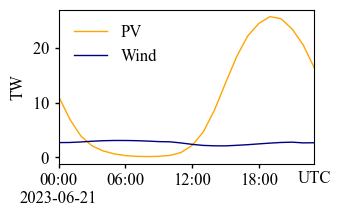

In [5]:
run_this_cell = True
if run_this_cell:
    pv_series = res_potential_dic['north_america']["pv"] * 1e-6 #TW
    wind_series = res_potential_dic['north_america']["wind"] * 1e-6 #TW 

    # Filter the data for the 21st of June, 2050
    date_of_interest = '2050-06-21'
    pv_june21 = pv_series[pv_series.index.strftime('%Y-%m-%d') == date_of_interest] 
    wind_june21 = wind_series[wind_series.index.strftime('%Y-%m-%d') == date_of_interest] 

    # Plotting the data
    plt.figure(figsize=(3.3, 2))
    plt.plot(pv_june21.index, pv_june21.values, label='PV', color='orange' , linewidth=1)
    plt.plot(wind_june21.index, wind_june21.values, label='Wind', color='navy', linewidth=1)
    plt.ylabel('TW')
    plt.xlim(pd.Timestamp('2050-06-21 00:00'), pd.Timestamp('2050-06-21 23:00'))
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    xticks = pd.date_range(start=date_of_interest, periods=5, freq='6h')
    xticks = xticks[:-1] 
    #plt.ylim(0, 9.5e1)
    plt.gca().set_xticks(xticks)
    ax = plt.gca()
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 3))  # Change the threshold for scientific notation
    ax.yaxis.set_major_formatter(formatter)
    tick_labels = [pd.to_datetime(t, unit='D').strftime('%H:%M') for t in xticks]
    plt.gca().set_xticklabels(tick_labels)
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
    plt.legend(frameon=False)
    plt.grid(False)
    plt.gca().annotate('2023-06-21', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
    plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')

    #plt.yticks([2e4, 4e4, 6e4, 8e4])
    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/res-time-series-hourly-output-example.svg', format='svg')
    plt.show()


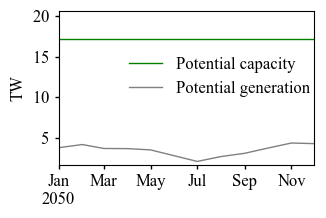

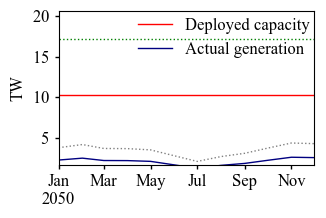

In [6]:
run_this_cell = True
if run_this_cell:
    pv_series = res_potential_dic['north_america']["cfs_pv"]
    wind_series = res_potential_dic['north_america']["cfs_wind"]

    max_wind_cap = res_potential_dic['north_america']["cap_wind"] *1e-6
    max_pv_cap = res_potential_dic['north_america']["cap_pv"] *1e-6

    pv_monthly = pv_series.groupby(pv_series.index.to_period('M')).mean()
    wind_monthly = wind_series.groupby(wind_series.index.to_period('M')).mean()
    wind_monthly_pot_gen = wind_monthly * max_wind_cap

    pv_monthly.index = pv_monthly.index.to_timestamp()
    wind_monthly.index = wind_monthly.index.to_timestamp()
    dates = wind_monthly.index

    plt.figure(figsize=(3.3, 2))
    plt.axhline(y=max_wind_cap, color='green', linestyle='-', label='Potential capacity', linewidth=1)
    plt.plot(wind_monthly.index, wind_monthly_pot_gen.values, color='grey', linewidth=1, label='Potential generation')
    #plt.xlim(pd.Timestamp('2050-01-01'), pd.Timestamp('2050-12-31'))
    plt.ylabel('TW')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
    plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
    xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
            pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
    xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
    plt.xticks(ticks=xticks, labels=xtick_labels)
    # Add 2050 below the Jan label
    plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')

    plt.grid(False)
    plt.ylim(0.1 * max_wind_cap, 1.2 * max_wind_cap)
    formatter1 = ScalarFormatter(useMathText=True)
    formatter1.set_powerlimits((0, 3))
    plt.gca().yaxis.set_major_formatter(formatter1)

    lines_1, labels_1 = plt.gca().get_legend_handles_labels()
    plt.legend(lines_1, labels_1, bbox_to_anchor=(1.04, 0.34), loc='lower right', frameon=False)

    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-potential-example.svg', format='svg')
    plt.show()

    wind_deployed = 0.6
    max_generation = max_wind_cap * wind_monthly
    actual_generation = wind_deployed * max_generation
    deployed_cap = max_wind_cap * wind_deployed

    plt.figure(figsize=(3.3, 2))
    plt.axhline(y=max_wind_cap, color='green', linestyle=':', linewidth=1)
    plt.axhline(y=deployed_cap, color='red', linestyle='-', label='Deployed capacity', linewidth=1)
    plt.plot(wind_monthly.index, max_generation, color='grey', linewidth=1, linestyle=':')
    plt.plot(wind_monthly.index, actual_generation, label='Actual generation', color='navy', linewidth=1)#
    plt.ylabel('TW')
    plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))

    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')

    # Add 2050 below the Jan label
    plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
    xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
            pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
    xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.grid(False)
    plt.ylim(0.1 * max_wind_cap, 1.2 * max_wind_cap)
    formatter1 = ScalarFormatter(useMathText=True)
    formatter1.set_powerlimits((0, 3))
    plt.gca().yaxis.set_major_formatter(formatter1)

    lines_1, labels_1 = plt.gca().get_legend_handles_labels()
    plt.legend(lines_1, labels_1, bbox_to_anchor=(1.04, 1.05), loc='upper right', frameon=False)

    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-deployment-example.svg', format='svg')
    plt.show()


## PyPSA --> Create the grid 

In [7]:
# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links 
for key, value in links_dic.items():
    n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
    n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['cap_wind'], p_max_pu=value["cfs_wind"][snapshots],p_min_pu=value["cfs_wind"][snapshots], capital_cost=cost_capacity_wind, marginal_cost=cost_generation_wind)
    n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['cap_pv'], p_max_pu=value["cfs_pv"][snapshots],p_min_pu=value["cfs_pv"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();

n.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]
INFO:linopy.io: Writing time: 4.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7eofdvfg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7eofdvfg.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3278715 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3278715 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3278715 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3278715 nonzeros


Model fingerprint: 0x9a2c7e06


INFO:gurobipy:Model fingerprint: 0x9a2c7e06


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-10, 1e+00]


INFO:gurobipy:  Matrix range     [3e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 5e+07]


INFO:gurobipy:  RHS range        [2e+03, 5e+07]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 894705 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 894705 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.691e+05


INFO:gurobipy: AA' NZ     : 3.691e+05


 Factor NZ  : 3.029e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.029e+06 (roughly 200 MB of memory)


 Factor Ops : 8.291e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.291e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.74264698e+13 -1.60606614e+13  5.49e+09 1.61e+00  1.14e+12     1s


INFO:gurobipy:   0   8.74264698e+13 -1.60606614e+13  5.49e+09 1.61e+00  1.14e+12     1s


   1   1.25682015e+14 -8.43873387e+13  9.76e+09 1.02e+02  6.24e+11     1s


INFO:gurobipy:   1   1.25682015e+14 -8.43873387e+13  9.76e+09 1.02e+02  6.24e+11     1s


   2   7.96112304e+13 -1.18077452e+14  8.31e+09 5.67e+01  3.99e+11     1s


INFO:gurobipy:   2   7.96112304e+13 -1.18077452e+14  8.31e+09 5.67e+01  3.99e+11     1s


   3   3.43685200e+13 -1.37229442e+14  2.77e+09 2.70e+01  1.76e+11     1s


INFO:gurobipy:   3   3.43685200e+13 -1.37229442e+14  2.77e+09 2.70e+01  1.76e+11     1s


   4   1.82016020e+13 -1.93054570e+14  1.29e+09 7.96e+00  7.36e+10     1s


INFO:gurobipy:   4   1.82016020e+13 -1.93054570e+14  1.29e+09 7.96e+00  7.36e+10     1s


   5   6.54315358e+12 -2.59529833e+14  4.23e+08 1.87e+00  2.37e+10     1s


INFO:gurobipy:   5   6.54315358e+12 -2.59529833e+14  4.23e+08 1.87e+00  2.37e+10     1s


   6   2.43167013e+12 -2.87394952e+14  1.26e+08 4.75e-01  7.32e+09     1s


INFO:gurobipy:   6   2.43167013e+12 -2.87394952e+14  1.26e+08 4.75e-01  7.32e+09     1s


   7   1.25789957e+12 -2.65735112e+14  4.22e+07 1.19e-01  2.57e+09     2s


INFO:gurobipy:   7   1.25789957e+12 -2.65735112e+14  4.22e+07 1.19e-01  2.57e+09     2s


   8   7.01023697e+11 -1.89226729e+14  2.98e+06 3.24e-02  5.17e+08     2s


INFO:gurobipy:   8   7.01023697e+11 -1.89226729e+14  2.98e+06 3.24e-02  5.17e+08     2s


   9   6.57356824e+11 -1.40403410e+13  0.00e+00 1.99e-03  3.18e+07     2s


INFO:gurobipy:   9   6.57356824e+11 -1.40403410e+13  0.00e+00 1.99e-03  3.18e+07     2s


  10   6.54397319e+11 -5.53973982e+10  0.00e+00 1.01e-04  1.54e+06     2s


INFO:gurobipy:  10   6.54397319e+11 -5.53973982e+10  0.00e+00 1.01e-04  1.54e+06     2s


  11   5.71087928e+11 -4.26351813e+10  0.00e+00 1.02e-04  1.33e+06     2s


INFO:gurobipy:  11   5.71087928e+11 -4.26351813e+10  0.00e+00 1.02e-04  1.33e+06     2s


  12   5.08611687e+11  2.99986264e+08  0.00e+00 2.43e-04  1.10e+06     2s


INFO:gurobipy:  12   5.08611687e+11  2.99986264e+08  0.00e+00 2.43e-04  1.10e+06     2s


  13   3.79746398e+11  2.44119157e+10  0.00e+00 8.13e-04  7.66e+05     2s


INFO:gurobipy:  13   3.79746398e+11  2.44119157e+10  0.00e+00 8.13e-04  7.66e+05     2s


  14   3.32602695e+11  1.76992079e+10  0.00e+00 2.92e-04  6.77e+05     2s


INFO:gurobipy:  14   3.32602695e+11  1.76992079e+10  0.00e+00 2.92e-04  6.77e+05     2s


  15   2.07716638e+11  2.17212872e+10  0.00e+00 2.95e-04  3.99e+05     3s


INFO:gurobipy:  15   2.07716638e+11  2.17212872e+10  0.00e+00 2.95e-04  3.99e+05     3s


  16   1.66977759e+11  3.16411811e+10  0.00e+00 2.99e-04  2.90e+05     3s


INFO:gurobipy:  16   1.66977759e+11  3.16411811e+10  0.00e+00 2.99e-04  2.90e+05     3s


  17   1.48363877e+11  3.35043116e+10  0.00e+00 3.02e-04  2.46e+05     3s


INFO:gurobipy:  17   1.48363877e+11  3.35043116e+10  0.00e+00 3.02e-04  2.46e+05     3s


  18   1.11987247e+11  3.98602001e+10  0.00e+00 3.60e-04  1.54e+05     4s


INFO:gurobipy:  18   1.11987247e+11  3.98602001e+10  0.00e+00 3.60e-04  1.54e+05     4s


  19   9.17311373e+10  4.56365744e+10  0.00e+00 7.47e-04  9.79e+04     4s


INFO:gurobipy:  19   9.17311373e+10  4.56365744e+10  0.00e+00 7.47e-04  9.79e+04     4s


  20   8.12961505e+10  5.07151176e+10  0.00e+00 8.89e-04  6.46e+04     4s


INFO:gurobipy:  20   8.12961505e+10  5.07151176e+10  0.00e+00 8.89e-04  6.46e+04     4s


  21   7.90688544e+10  5.33868976e+10  0.00e+00 8.25e-04  5.41e+04     4s


INFO:gurobipy:  21   7.90688544e+10  5.33868976e+10  0.00e+00 8.25e-04  5.41e+04     4s


  22   7.62868140e+10  5.52910605e+10  0.00e+00 7.62e-04  4.41e+04     4s


INFO:gurobipy:  22   7.62868140e+10  5.52910605e+10  0.00e+00 7.62e-04  4.41e+04     4s


  23   7.55883299e+10  5.61649169e+10  0.00e+00 7.47e-04  4.07e+04     5s


INFO:gurobipy:  23   7.55883299e+10  5.61649169e+10  0.00e+00 7.47e-04  4.07e+04     5s


  24   7.32112064e+10  5.91695934e+10  0.00e+00 6.48e-04  2.93e+04     5s


INFO:gurobipy:  24   7.32112064e+10  5.91695934e+10  0.00e+00 6.48e-04  2.93e+04     5s


  25   7.23251452e+10  6.08365933e+10  0.00e+00 5.57e-04  2.40e+04     5s


INFO:gurobipy:  25   7.23251452e+10  6.08365933e+10  0.00e+00 5.57e-04  2.40e+04     5s


  26   7.16921342e+10  6.35735777e+10  0.00e+00 4.97e-04  1.69e+04     5s


INFO:gurobipy:  26   7.16921342e+10  6.35735777e+10  0.00e+00 4.97e-04  1.69e+04     5s


  27   7.13731784e+10  6.46307720e+10  0.00e+00 4.22e-04  1.40e+04     5s


INFO:gurobipy:  27   7.13731784e+10  6.46307720e+10  0.00e+00 4.22e-04  1.40e+04     5s


  28   7.11636008e+10  6.66864181e+10  0.00e+00 3.23e-04  9.31e+03     6s


INFO:gurobipy:  28   7.11636008e+10  6.66864181e+10  0.00e+00 3.23e-04  9.31e+03     6s


  29   7.11255246e+10  6.71148952e+10  0.00e+00 3.06e-04  8.34e+03     6s


INFO:gurobipy:  29   7.11255246e+10  6.71148952e+10  0.00e+00 3.06e-04  8.34e+03     6s


  30   7.10147687e+10  6.73666932e+10  0.00e+00 2.93e-04  7.58e+03     6s


INFO:gurobipy:  30   7.10147687e+10  6.73666932e+10  0.00e+00 2.93e-04  7.58e+03     6s


  31   7.09053944e+10  6.88345623e+10  0.00e+00 2.07e-04  4.30e+03     6s


INFO:gurobipy:  31   7.09053944e+10  6.88345623e+10  0.00e+00 2.07e-04  4.30e+03     6s


  32   7.08004736e+10  7.01166150e+10  0.00e+00 1.07e-04  1.42e+03     6s


INFO:gurobipy:  32   7.08004736e+10  7.01166150e+10  0.00e+00 1.07e-04  1.42e+03     6s


  33   7.07773030e+10  7.04238568e+10  0.00e+00 5.45e-05  7.34e+02     7s


INFO:gurobipy:  33   7.07773030e+10  7.04238568e+10  0.00e+00 5.45e-05  7.34e+02     7s


  34   7.07485296e+10  7.04397892e+10  0.00e+00 5.16e-05  6.39e+02     7s


INFO:gurobipy:  34   7.07485296e+10  7.04397892e+10  0.00e+00 5.16e-05  6.39e+02     7s


  35   7.07424528e+10  7.05174358e+10  0.00e+00 3.73e-05  4.66e+02     7s


INFO:gurobipy:  35   7.07424528e+10  7.05174358e+10  0.00e+00 3.73e-05  4.66e+02     7s


  36   7.07384522e+10  7.05694524e+10  0.00e+00 2.65e-05  3.50e+02     7s


INFO:gurobipy:  36   7.07384522e+10  7.05694524e+10  0.00e+00 2.65e-05  3.50e+02     7s


  37   7.07337884e+10  7.06434950e+10  0.00e+00 1.08e-05  1.87e+02     7s


INFO:gurobipy:  37   7.07337884e+10  7.06434950e+10  0.00e+00 1.08e-05  1.87e+02     7s


  38   7.07170696e+10  7.06884172e+10  0.00e+00 2.56e-06  5.87e+01     7s


INFO:gurobipy:  38   7.07170696e+10  7.06884172e+10  0.00e+00 2.56e-06  5.87e+01     7s


  39   7.07076806e+10  7.07000710e+10  0.00e+00 3.60e-06  1.43e+01     8s


INFO:gurobipy:  39   7.07076806e+10  7.07000710e+10  0.00e+00 3.60e-06  1.43e+01     8s


  40   7.07056391e+10  7.07012803e+10  0.00e+00 3.15e-06  7.48e+00     8s


INFO:gurobipy:  40   7.07056391e+10  7.07012803e+10  0.00e+00 3.15e-06  7.48e+00     8s


  41   7.07046928e+10  7.07017582e+10  0.00e+00 2.76e-06  4.51e+00     8s


INFO:gurobipy:  41   7.07046928e+10  7.07017582e+10  0.00e+00 2.76e-06  4.51e+00     8s


  42   7.07040111e+10  7.07020117e+10  0.00e+00 2.81e-06  2.58e+00     8s


INFO:gurobipy:  42   7.07040111e+10  7.07020117e+10  0.00e+00 2.81e-06  2.58e+00     8s


  43   7.07036820e+10  7.07021772e+10  0.00e+00 2.85e-06  1.58e+00     8s


INFO:gurobipy:  43   7.07036820e+10  7.07021772e+10  0.00e+00 2.85e-06  1.58e+00     8s


  44   7.07034395e+10  7.07022488e+10  0.00e+00 2.87e-06  9.44e-01     9s


INFO:gurobipy:  44   7.07034395e+10  7.07022488e+10  0.00e+00 2.87e-06  9.44e-01     9s


  45   7.07033150e+10  7.07022812e+10  0.00e+00 2.88e-06  6.36e-01     9s


INFO:gurobipy:  45   7.07033150e+10  7.07022812e+10  0.00e+00 2.88e-06  6.36e-01     9s


  46   7.07032628e+10  7.07022974e+10  0.00e+00 2.88e-06  5.05e-01     9s


INFO:gurobipy:  46   7.07032628e+10  7.07022974e+10  0.00e+00 2.88e-06  5.05e-01     9s


  47   7.07032123e+10  7.07023128e+10  0.00e+00 2.89e-06  3.82e-01     9s


INFO:gurobipy:  47   7.07032123e+10  7.07023128e+10  0.00e+00 2.89e-06  3.82e-01     9s


  48   7.07031674e+10  7.07023236e+10  0.00e+00 2.88e-06  2.80e-01     9s


INFO:gurobipy:  48   7.07031674e+10  7.07023236e+10  0.00e+00 2.88e-06  2.80e-01     9s


  49   7.07031333e+10  7.07023393e+10  0.00e+00 2.87e-06  1.91e-01     9s


INFO:gurobipy:  49   7.07031333e+10  7.07023393e+10  0.00e+00 2.87e-06  1.91e-01     9s


  50   7.07031044e+10  7.07023467e+10  0.00e+00 2.83e-06  1.30e-01     9s


INFO:gurobipy:  50   7.07031044e+10  7.07023467e+10  0.00e+00 2.83e-06  1.30e-01     9s


  51   7.07030869e+10  7.07023499e+10  0.00e+00 2.70e-06  9.61e-02    10s


INFO:gurobipy:  51   7.07030869e+10  7.07023499e+10  0.00e+00 2.70e-06  9.61e-02    10s


  52   7.07030774e+10  7.07023508e+10  0.00e+00 2.24e-06  7.90e-02    10s


INFO:gurobipy:  52   7.07030774e+10  7.07023508e+10  0.00e+00 2.24e-06  7.90e-02    10s


  53   7.07030756e+10  7.07023515e+10  0.00e+00 2.25e-06  7.52e-02    10s


INFO:gurobipy:  53   7.07030756e+10  7.07023515e+10  0.00e+00 2.25e-06  7.52e-02    10s


  54   7.07030698e+10  7.07023527e+10  0.00e+00 2.28e-06  6.50e-02    10s


INFO:gurobipy:  54   7.07030698e+10  7.07023527e+10  0.00e+00 2.28e-06  6.50e-02    10s


  55   7.07030569e+10  7.07023537e+10  0.00e+00 2.29e-06  4.25e-02    10s


INFO:gurobipy:  55   7.07030569e+10  7.07023537e+10  0.00e+00 2.29e-06  4.25e-02    10s


  56   7.07030490e+10  7.07023547e+10  0.00e+00 2.30e-06  2.98e-02    10s


INFO:gurobipy:  56   7.07030490e+10  7.07023547e+10  0.00e+00 2.30e-06  2.98e-02    10s


  57   7.07030432e+10  7.07023553e+10  0.00e+00 2.28e-06  2.17e-02    11s


INFO:gurobipy:  57   7.07030432e+10  7.07023553e+10  0.00e+00 2.28e-06  2.17e-02    11s


  58   7.07030421e+10  7.07023555e+10  0.00e+00 2.25e-06  2.01e-02    11s


INFO:gurobipy:  58   7.07030421e+10  7.07023555e+10  0.00e+00 2.25e-06  2.01e-02    11s


  59   7.07030388e+10  7.07023558e+10  0.00e+00 2.21e-06  1.62e-02    11s


INFO:gurobipy:  59   7.07030388e+10  7.07023558e+10  0.00e+00 2.21e-06  1.62e-02    11s


  60   7.07030358e+10  7.07023559e+10  0.00e+00 2.20e-06  1.23e-02    11s


INFO:gurobipy:  60   7.07030358e+10  7.07023559e+10  0.00e+00 2.20e-06  1.23e-02    11s


  61   7.07030341e+10  7.07023561e+10  0.00e+00 2.19e-06  1.03e-02    11s


INFO:gurobipy:  61   7.07030341e+10  7.07023561e+10  0.00e+00 2.19e-06  1.03e-02    11s


  62   7.07030316e+10  7.07023563e+10  0.00e+00 2.19e-06  7.70e-03    11s


INFO:gurobipy:  62   7.07030316e+10  7.07023563e+10  0.00e+00 2.19e-06  7.70e-03    11s


  63   7.07030302e+10  7.07023565e+10  0.00e+00 2.17e-06  6.36e-03    11s


INFO:gurobipy:  63   7.07030302e+10  7.07023565e+10  0.00e+00 2.17e-06  6.36e-03    11s


  64   7.07030288e+10  7.07023565e+10  0.00e+00 2.17e-06  5.15e-03    11s


INFO:gurobipy:  64   7.07030288e+10  7.07023565e+10  0.00e+00 2.17e-06  5.15e-03    11s


  65   7.07030285e+10  7.07023566e+10  0.00e+00 2.17e-06  4.90e-03    12s


INFO:gurobipy:  65   7.07030285e+10  7.07023566e+10  0.00e+00 2.17e-06  4.90e-03    12s


  66   7.07030272e+10  7.07023569e+10  0.00e+00 2.17e-06  4.01e-03    12s


INFO:gurobipy:  66   7.07030272e+10  7.07023569e+10  0.00e+00 2.17e-06  4.01e-03    12s


  67   7.07030261e+10  7.07023572e+10  0.00e+00 2.16e-06  3.28e-03    12s


INFO:gurobipy:  67   7.07030261e+10  7.07023572e+10  0.00e+00 2.16e-06  3.28e-03    12s


  68   7.07030250e+10  7.07023574e+10  0.00e+00 2.16e-06  2.67e-03    12s


INFO:gurobipy:  68   7.07030250e+10  7.07023574e+10  0.00e+00 2.16e-06  2.67e-03    12s


  69   7.07030240e+10  7.07023576e+10  0.00e+00 2.16e-06  2.24e-03    12s


INFO:gurobipy:  69   7.07030240e+10  7.07023576e+10  0.00e+00 2.16e-06  2.24e-03    12s


  70   7.07030231e+10  7.07023578e+10  0.00e+00 2.16e-06  1.90e-03    12s


INFO:gurobipy:  70   7.07030231e+10  7.07023578e+10  0.00e+00 2.16e-06  1.90e-03    12s


  71   7.07030224e+10  7.07023580e+10  0.00e+00 2.16e-06  1.64e-03    12s


INFO:gurobipy:  71   7.07030224e+10  7.07023580e+10  0.00e+00 2.16e-06  1.64e-03    12s


  72   7.07030215e+10  7.07023581e+10  0.00e+00 2.16e-06  1.36e-03    13s


INFO:gurobipy:  72   7.07030215e+10  7.07023581e+10  0.00e+00 2.16e-06  1.36e-03    13s


INFO:gurobipy:


Barrier solved model in 72 iterations and 12.57 seconds (16.27 work units)


INFO:gurobipy:Barrier solved model in 72 iterations and 12.57 seconds (16.27 work units)


Optimal objective 7.07030215e+10


INFO:gurobipy:Optimal objective 7.07030215e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  110515 variables added to crossover basis                       15s


INFO:gurobipy:  110515 variables added to crossover basis                       15s


INFO:gurobipy:


    3066 DPushes remaining with DInf 1.0043234e-03                15s


INFO:gurobipy:    3066 DPushes remaining with DInf 1.0043234e-03                15s


       0 DPushes remaining with DInf 1.0514204e-03                15s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0514204e-03                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  186998 PPushes remaining with PInf 1.7584605e-02                15s


INFO:gurobipy:  186998 PPushes remaining with PInf 1.7584605e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0600882e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0600882e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  189755    7.0703030e+10   0.000000e+00   1.060088e+00     16s


INFO:gurobipy:  189755    7.0703030e+10   0.000000e+00   1.060088e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 437


INFO:gurobipy:Extra simplex iterations after uncrush: 437


  226018    7.0702410e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  226018    7.0702410e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 226018 iterations and 18.68 seconds (27.86 work units)


INFO:gurobipy:Solved in 226018 iterations and 18.68 seconds (27.86 work units)


Optimal objective  7.070241012e+10


INFO:gurobipy:Optimal objective  7.070241012e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.07e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

## Installed capacities

In [8]:
asia = ['north_asia', 'south_asia', 'south_west_asia']
eurasia = ['ups', 'north_west_asia']
africa = ['north_africa', 'africa']
irena_regions = ['africa', 'asia', 'middle_east', 'eurasia', 'oceania', 'europe', 'north_america', 'south_america']
irena_pv_values = []
irena_regions_dict = {
    'africa': {'region': africa},
    'asia': {'region': asia},
    'middle_east': {'region': ['middle_east']},
    'eurasia': {'region': eurasia},
    'oceania': {'region': ['oceania']},
    'europe': {'region': ['europe']},
    'north_america': {'region': ['north_america']},
    'atlantic_north': {'region': ['atlantic_north']},
    'latin_america': {'region': ['latin_america']}
}
actual_pv_data = { #GW
    'world': 1053.12,
    'asia': 597.57,
    'europe': 229.62,
    'north_america': 126.44,
    'latin_america': 32.77 + 3.99,
    'oceania': 27.40,
    'middle_east': 12.88,
    'africa': 12.64,
    'eurasia': 11.62,
    'atlantic_north': 0
}

actual_wind_data = { #GW
    'world': 898.82,
    'asia': 425.67,
    'europe': 240.62,
    'north_america': 163.47,
    'latin_america': 33.47 + 2.04,
    'eurasia': 13.71,
    'oceania': 11.10,
    'africa': 7.68,
    'middle_east': 1.05,
    'atlantic_north': 0
}

for key, value in irena_regions_dict.items():
    value['wind'] = {}
    value['pv'] = {}
    wind = 0
    pv = 0
    for region in value['region']:
        wind += n.generators.p_nom_opt[f'wind_{region}'] * 1e-3
        pv += n.generators.p_nom_opt[f'pv_{region}'] * 1e-3
    value['wind'] = wind
    value['pv'] = pv
irena_regions_dict

{'africa': {'region': ['north_africa', 'africa'],
  'wind': 3229.3926025321452,
  'pv': 1728.8975354675836},
 'asia': {'region': ['north_asia', 'south_asia', 'south_west_asia'],
  'wind': 16806.544994693235,
  'pv': 0.0},
 'middle_east': {'region': ['middle_east'],
  'wind': 3991.9516788170076,
  'pv': 0.0},
 'eurasia': {'region': ['ups', 'north_west_asia'],
  'wind': 2464.587466015989,
  'pv': 1265.8050034000373},
 'oceania': {'region': ['oceania'],
  'wind': 1647.0418260914269,
  'pv': 2494.7434698537886},
 'europe': {'region': ['europe'],
  'wind': 3013.6073631677573,
  'pv': 1974.1701228487245},
 'north_america': {'region': ['north_america'],
  'wind': 4685.031542626408,
  'pv': 4202.22738174392},
 'atlantic_north': {'region': ['atlantic_north'],
  'wind': 1135.7794175183608,
  'pv': 0.0},
 'latin_america': {'region': ['latin_america'],
  'wind': 3967.301139958894,
  'pv': 303.90660213893784}}

asia
north_america
middle_east
latin_america
africa
europe
oceania
eurasia
atlantic_north


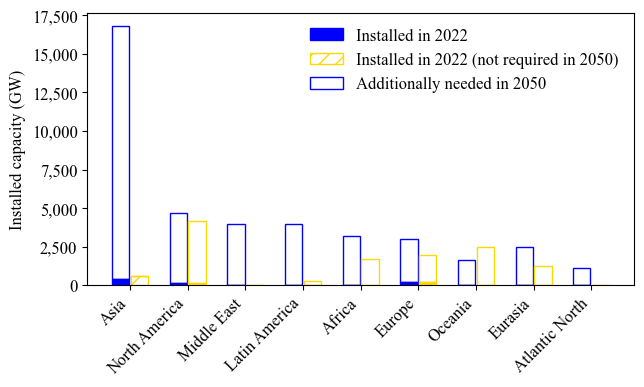

In [9]:
# world_wind = sum([value['wind'] for value in irena_regions_dict.values()])
# world_pv = sum([value['pv'] for value in irena_regions_dict.values()])
#irena_regions_dict['world'] = {'region': ['world'], 'wind': world_wind, 'pv': world_pv}
regions = list(irena_regions_dict.keys())
wind_values_diff = [irena_regions_dict[region]['wind'] - actual_wind_data[region] if irena_regions_dict[region]['wind'] - actual_wind_data[region] >=0 else 0  for region in regions]
pv_values_diff = [irena_regions_dict[region]['pv'] - actual_pv_data[region] if irena_regions_dict[region]['pv'] - actual_pv_data[region] >=0 else 0 for region in regions]
actual_wind_values = [actual_wind_data[region] for region in regions]
actual_pv_values = [actual_pv_data[region] for region in regions]

data = [
    (
        region, 
        actual_wind_data[region], 
        actual_pv_data[region], 
        irena_regions_dict[region]['wind'] - actual_wind_data[region] if irena_regions_dict[region]['wind'] - actual_wind_data[region] >= 0 else 0, 
        irena_regions_dict[region]['pv'] - actual_pv_data[region] if irena_regions_dict[region]['pv'] - actual_pv_data[region] >= 0 else 0
    )
    for region in irena_regions_dict.keys()
]

# Sort data by the highest value which is the sum of diff and the actual
data.sort(key=lambda x: max(x[1] + x[3], x[2] + x[4]), reverse=True)

regions = [item[0] for item in data]
actual_wind_values = [item[1] for item in data]
actual_pv_values= [item[2] for item in data]
wind_values_diff = [item[3] for item in data]
pv_values_diff = [item[4] for item in data]



fig, ax = plt.subplots(figsize=(6.6, 4))

# Bar chart for Wind and PV values by Region
bar_width = 0.3
mult = 1.08
x = np.arange(len(regions))

for i, region in enumerate(regions):
    print(region)
    hatch_pv = '//' if region in ['asia'] else ''
    color_pv = 'none' if region in ['asia'] else 'gold'
    label_pv = 'Installed in 2022 (not required in 2050)' if region in ['asia'] else None
    ax.bar(x[i] - bar_width / 2 * mult, actual_wind_values[i], bar_width, label='Installed in 2022' if i == 0 else "", color='blue', edgecolor='blue')
    ax.bar(x[i] + bar_width / 2 * mult, actual_pv_values[i], bar_width, color=color_pv, edgecolor='gold', hatch=hatch_pv, label=label_pv)
    ax.bar(x[i] - bar_width / 2 * mult, wind_values_diff[i], bar_width, bottom=actual_wind_values[i], label='Additionally needed in 2050' if i == 0 else "", color='none', edgecolor='blue')
    ax.bar(x[i] + bar_width / 2 * mult, pv_values_diff[i], bar_width, bottom=actual_pv_values[i], color='none', edgecolor='gold')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels([region.replace('_', ' ').title() for region in regions], rotation=45, ha='right')
ax.set_ylabel('Installed capacity (GW)')
ax.legend(frameon=False)

def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)

# Adjust layout
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/bar-chart-installed-cap.pdf', format='pdf')

plt.show()

# **ANALYSIS OF GLOBAL GRID**

## Caluclate installed capacity, generation, curtailment and demand for each region

In [10]:
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
    
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
 
for key, value in regions_dic.items():
    # Generation data of each node
    for carrier in ["pv", "wind"]:
        series_g = n.generators_t.p[f"{carrier}_{key}"] * 1e-3 # GW
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # GW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # GWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # GW
        regions_dic[key][f"total_{carrier}_daily"] = series_g.groupby(series_g.index.date).sum() # GW
    # Curtailment data of each node
    series_c = n.generators_t.p[f"curtailment_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_curtailment_daily"] = series_c.groupby(series_c.index.date).sum() # GW
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # GW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # GWh
    # Demand data of each node
    series_l = n.loads_t.p[f"load_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # GWh
    
# Daily hourly values of specific days
dates = pd.to_datetime([f"{scenario_year}-03-21", f"{scenario_year}-06-21", f"{scenario_year}-09-21", f"{scenario_year}-12-21", f"{scenario_year}-04-06"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
        regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day

## Calculate hourly time series of generation, curtailment, and load

In [11]:
# Sum generation and loads of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
total_hourly_wind = pd.Series(0, index=n.snapshots)
total_hourly_pv = pd.Series(0, index=n.snapshots)
total_hourly_cur = pd.Series(0, index=n.snapshots)
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
    total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
    total_hourly_pv += n.generators_t.p[f"pv_{key}"]
    total_hourly_wind += n.generators_t.p[f"wind_{key}"]
    total_hourly_load += n.loads_t.p[f"load_{key}"]
    
# Generation total
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Generation wind
total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
total_annual_wind = total_hourly_wind.sum()

# Generation pv
total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
total_annual_pv = total_hourly_pv.sum()

# Curtailment
total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
total_annual_cur = total_hourly_cur.sum()

# Curtailment std and mean
mean_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).mean()
std_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).std()

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()


## Calculate global relative transmission, curtailment, and losses  

In [12]:
# Store hourly losses for each link in dictionary
for key, value in links_dic.items():
    p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
    p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
    abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
    p_trans = p0_0 + p0_1
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Sum the transmission and losses of the links
total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
total_hourly_p_trans = pd.Series(0, index=n.snapshots)
for key, value in links_dic.items():
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Losses std and mean 
total_monthly_losses_std = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).std()
total_monthly_losses_mean = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).mean()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses to transmission
hourly_rel_losses = total_hourly_abs_losses / total_hourly_p_trans
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses to transmission
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

# Losses relative to load
hourly_losses_rel_to_load = total_hourly_abs_losses / total_hourly_load
daily_losses_rel_to_load = total_daily_abs_losses / total_daily_load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Curtailment relative to gen
hourly_cur_rel_to_gen = total_hourly_cur / total_hourly_gen
daily_cur_rel_to_gen = total_daily_cur / total_daily_gen
monthly_cur_rel_to_gen = total_monthly_cur / total_monthly_gen
annual_cur_rel_to_gen = total_annual_cur / total_annual_gen

# Curtailment relative to load
hourly_cur_rel_to_load = total_hourly_cur / total_hourly_load
daily_cur_rel_to_load = total_daily_cur / total_daily_load
monthly_cur_rel_to_load = total_monthly_cur / total_monthly_load
annual_cur_rel_to_load = total_annual_cur / total_annual_load

# Power transmitted rel to gen
hourly_p_trans_rel_gen = total_hourly_p_trans / total_hourly_gen
daily_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_gen
monthly_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_gen
annual_p_trans_rel_gen = total_hourly_p_trans.sum() / total_annual_gen

# Power transmitted rel to load
hourly_p_trans_rel_load= total_hourly_p_trans / total_hourly_load
daily_p_trans_rel_load = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_load
monthly_p_trans_rel_load = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_load
annual_p_trans_rel_load = total_hourly_p_trans.sum() / total_annual_load

## Calculate inflows, outflows, and net flows for each region

In [13]:
# Calculate inflow, outflow, and 
for region_key, region_value in regions_dic.items():
    inflow = 0
    outflow = 0
    inflow_series = pd.Series(0, index=n.snapshots)
    outflow_series = pd.Series(0, index=n.snapshots)
    for link_key, link_value in links_dic.items():
        if region_value["bus"] == link_value["bus0"][0]: 
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"] # link from region_value["bus"] to bus1: negative --> outfow at region_value["bus"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"] # link from bus1 to region_value["bus"]: positive --> inflow at region_value["bus"] after efficiency losses
            sum_p0_0 = abs(sum(p0_0)) 
            sum_p1_1 = abs(sum(p1_1))
            outflow += sum_p0_0
            inflow += sum_p1_1
            outflow_series += p0_0.abs()
            inflow_series += p1_1.abs()
        elif region_value["bus"] == link_value["bus1"][0]:
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"] # Link from region_value["bus"] to bus0: negative --> outfow at region_value["bus"]
            p1_0 = n.links_t.p1[f"{link_value["name"]}_0"] # link from bus0 to region_value["bus"]: positive --> inflow at region_value["bus"] after efficiency losses
            sum_p0_1 = sum(p0_1.abs())
            sum_p1_0 = sum(p1_0.abs())
            outflow += sum_p0_1
            inflow += sum_p1_0
            outflow_series += p0_1.abs()
            inflow_series += p1_0.abs()
    netflow = (outflow - inflow) 
    netflow_series = (outflow_series - inflow_series) 
    region_value["inflow"] = inflow * 1e-3 # GWh
    region_value["outflow"] = outflow * 1e-3 # GWh
    region_value["inflow_series"] = inflow_series * 1e-3 # GW
    region_value["outflow_series"] = outflow_series * 1e-3 # GW
    region_value["netflow"] = netflow * 1e-3 # GWh
    region_value["netflow_series"] = netflow_series * 1e-3 # GW
    region_value["actualflow"] = (outflow_series.abs() - inflow_series.abs()) * 1e-3 # GW
    region_value["actualflow"] = np.where(region_value["actualflow"] < 0, 0, region_value["actualflow"])
    region_value['total_actualflow'] = region_value["actualflow"].sum()



In [14]:
# Compute total power transmitted for each hour
total_actual_flow = pd.Series(0, index=n.snapshots)
total_actual_flow_int = 0
for key, value in regions_dic.items():
    total_actual_flow += value["actualflow"]
    total_actual_flow_int += value["total_actualflow"]

# Actual flow 
hourly_actual_flow_rel_gen = total_actual_flow / total_hourly_gen

def flow_direction(date=None):
    # Compute inflow, outflow direction per link
    flow_statements = {}
    netflows_links = {}
    netflows_links_series = {}
    for link_key, link_value in links_dic.items():
        if date == None:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p0_1 = abs(sum(p1_1))
            netflows_links[link_key] = abs(sum_p0_0 - sum_p0_1)
            netflows_links_series[link_key] = (p0_0 - p0_1) * 1e-3 #GW
            if sum_p0_0 > sum_p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        else:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"][date]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"][date]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"][date]
            net_flow = abs(p0_0 - p0_1)
            if p0_0 > p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        
    return flow_statements, netflows_links, netflows_links_series
flow_statements = flow_direction()[0]
netflows_links = flow_direction()[1]
netflows_links_series = flow_direction()[2]

# Calculation of monthly inflows and outflows
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')
month_to_period = {month: period for month, period in zip(months, month_periods)}
for i, month in enumerate(months):
    period = month_to_period[month]
    for region_key, region_value in regions_dic.items():
        inflow = 0
        outflow = 0
        for link_key, link_value in links_dic.items():
            if region_value["bus"] == link_value["bus0"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
            elif region_value["bus"] == link_value["bus1"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_1"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_0"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
        region_value[f"inflow_{month}"] = inflow * 1e-3 # GW
        region_value[f"outflow_{month}"] = outflow * 1e-3 # GW
        region_value[f"netflow_{month}"] = (inflow - outflow) * 1e-3 # GW

## Losses per node

In [15]:
for key, value in regions_dic.items():
    net_inflow = np.where(value["netflow_series"] > 0, 0, value["netflow_series"])
    annual_net_inflow = net_inflow.sum()
    annual_load = value['total_load_yearly']
    share_inflow_consumption = annual_net_inflow / annual_load * 100

# **Evaluation of results**

## Overview of global grid

In [16]:
wind_share = total_annual_wind / total_annual_gen * 100
pv_share = 100 - wind_share
sum_netflow = 0
for key, value in regions_dic.items():
    netflow = value['netflow'] * 1e3
    if netflow > 0:
        sum_netflow += value['netflow'] * 1e3
print('NO TRANSMISSION COST')
print(f'Total generation: {total_annual_gen:.2e}')
print(f'Wind: {round(wind_share, 1)} PV: {round(pv_share, 1)}')
print(f'Total generation: {total_annual_load:.2e}')
print(f'Total curtailment: {total_annual_cur:.2e}')
print(f'Total transmission: {total_annual_p_trans:.2e}')
print(f'Total transmission share of gen: {round(total_annual_p_trans/total_annual_gen*100, 2)}%')
print(f'Total net transmission: {sum_netflow:.2e}')
print(f'Total net transmission share of gen: {round(sum_netflow/total_annual_gen*100, 2)}%')
print(f'Total net transmission share of demand: {round(sum_netflow/total_annual_load*100, 2)}%')
print(f'Total transmission losses: {round(annual_losses_rel_to_gen, 3)}')


NO TRANSMISSION COST
Total generation: 7.06e+10
Wind: 75.7 PV: 24.3
Total generation: 5.16e+10
Total curtailment: 1.69e+10
Total transmission: 3.09e+10
Total transmission share of gen: 43.72%
Total net transmission: 1.74e+10
Total net transmission share of gen: 24.56%
Total net transmission share of demand: 33.62%
Total transmission losses: 0.03


## Plotting of inflow and outflow series

In [17]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        inflow_series = - regions_dic[key]['inflow_series']
        ax = axs[idx]
        ax.plot(inflow_series, linewidth=0.6)
        ax.set_title(f'Inflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Inflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

    for idx, (key, value) in enumerate(regions_dic.items()):
        outflow_series = regions_dic[key]['outflow_series']
        ax = axs[idx]
        ax.plot(curtailment_series, linewidth=0.6)
        ax.set_title(f'Outflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Outflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## Regional share of wind and solar

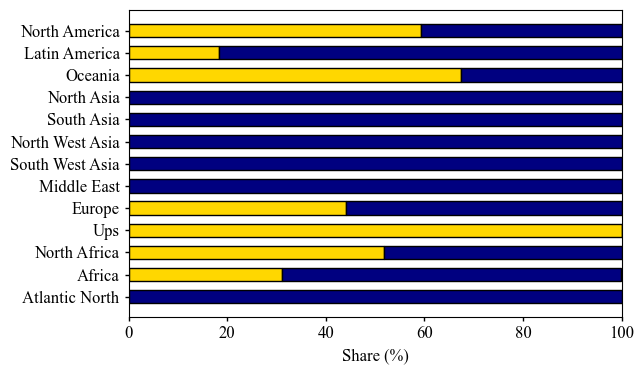

In [18]:
# Calculate shares
regions = []
pv_cap_shares = []
wind_cap_shares = []
pv_gen_shares = []
wind_gen_shares = []

for key, value in regions_dic.items():
    regions.append(key)
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    pv_cap_shares.append(pv_cap_share)
    wind_cap_shares.append(wind_cap_share)
    pv_gen_shares.append(pv_gen_share)
    wind_gen_shares.append(wind_gen_share)

num_regions = len(regions)

# Create figure and axes
fig, ax = plt.subplots(figsize=(6.6, num_regions * 0.3))

bar_width = 0.6
y_positions = np.arange(num_regions)
ax.barh(y_positions , pv_cap_shares, height=bar_width, color='gold', edgecolor='black', label='Solar PV')
ax.barh(y_positions, wind_cap_shares, height=bar_width, left=pv_cap_shares, color='navy', edgecolor='black', label='Wind')
formatted_regions = [region.replace('_', ' ').title() for region in regions]
ax.set_yticks(y_positions)
ax.set_yticklabels(formatted_regions, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Share (%)', fontsize=12)
ax.invert_yaxis()
ax.grid(True, axis='x')
ax.grid(False)
ax.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/bar-chart-wind-solar-share.pdf', format='pdf')

plt.show()


## Plotting of monthly regional data

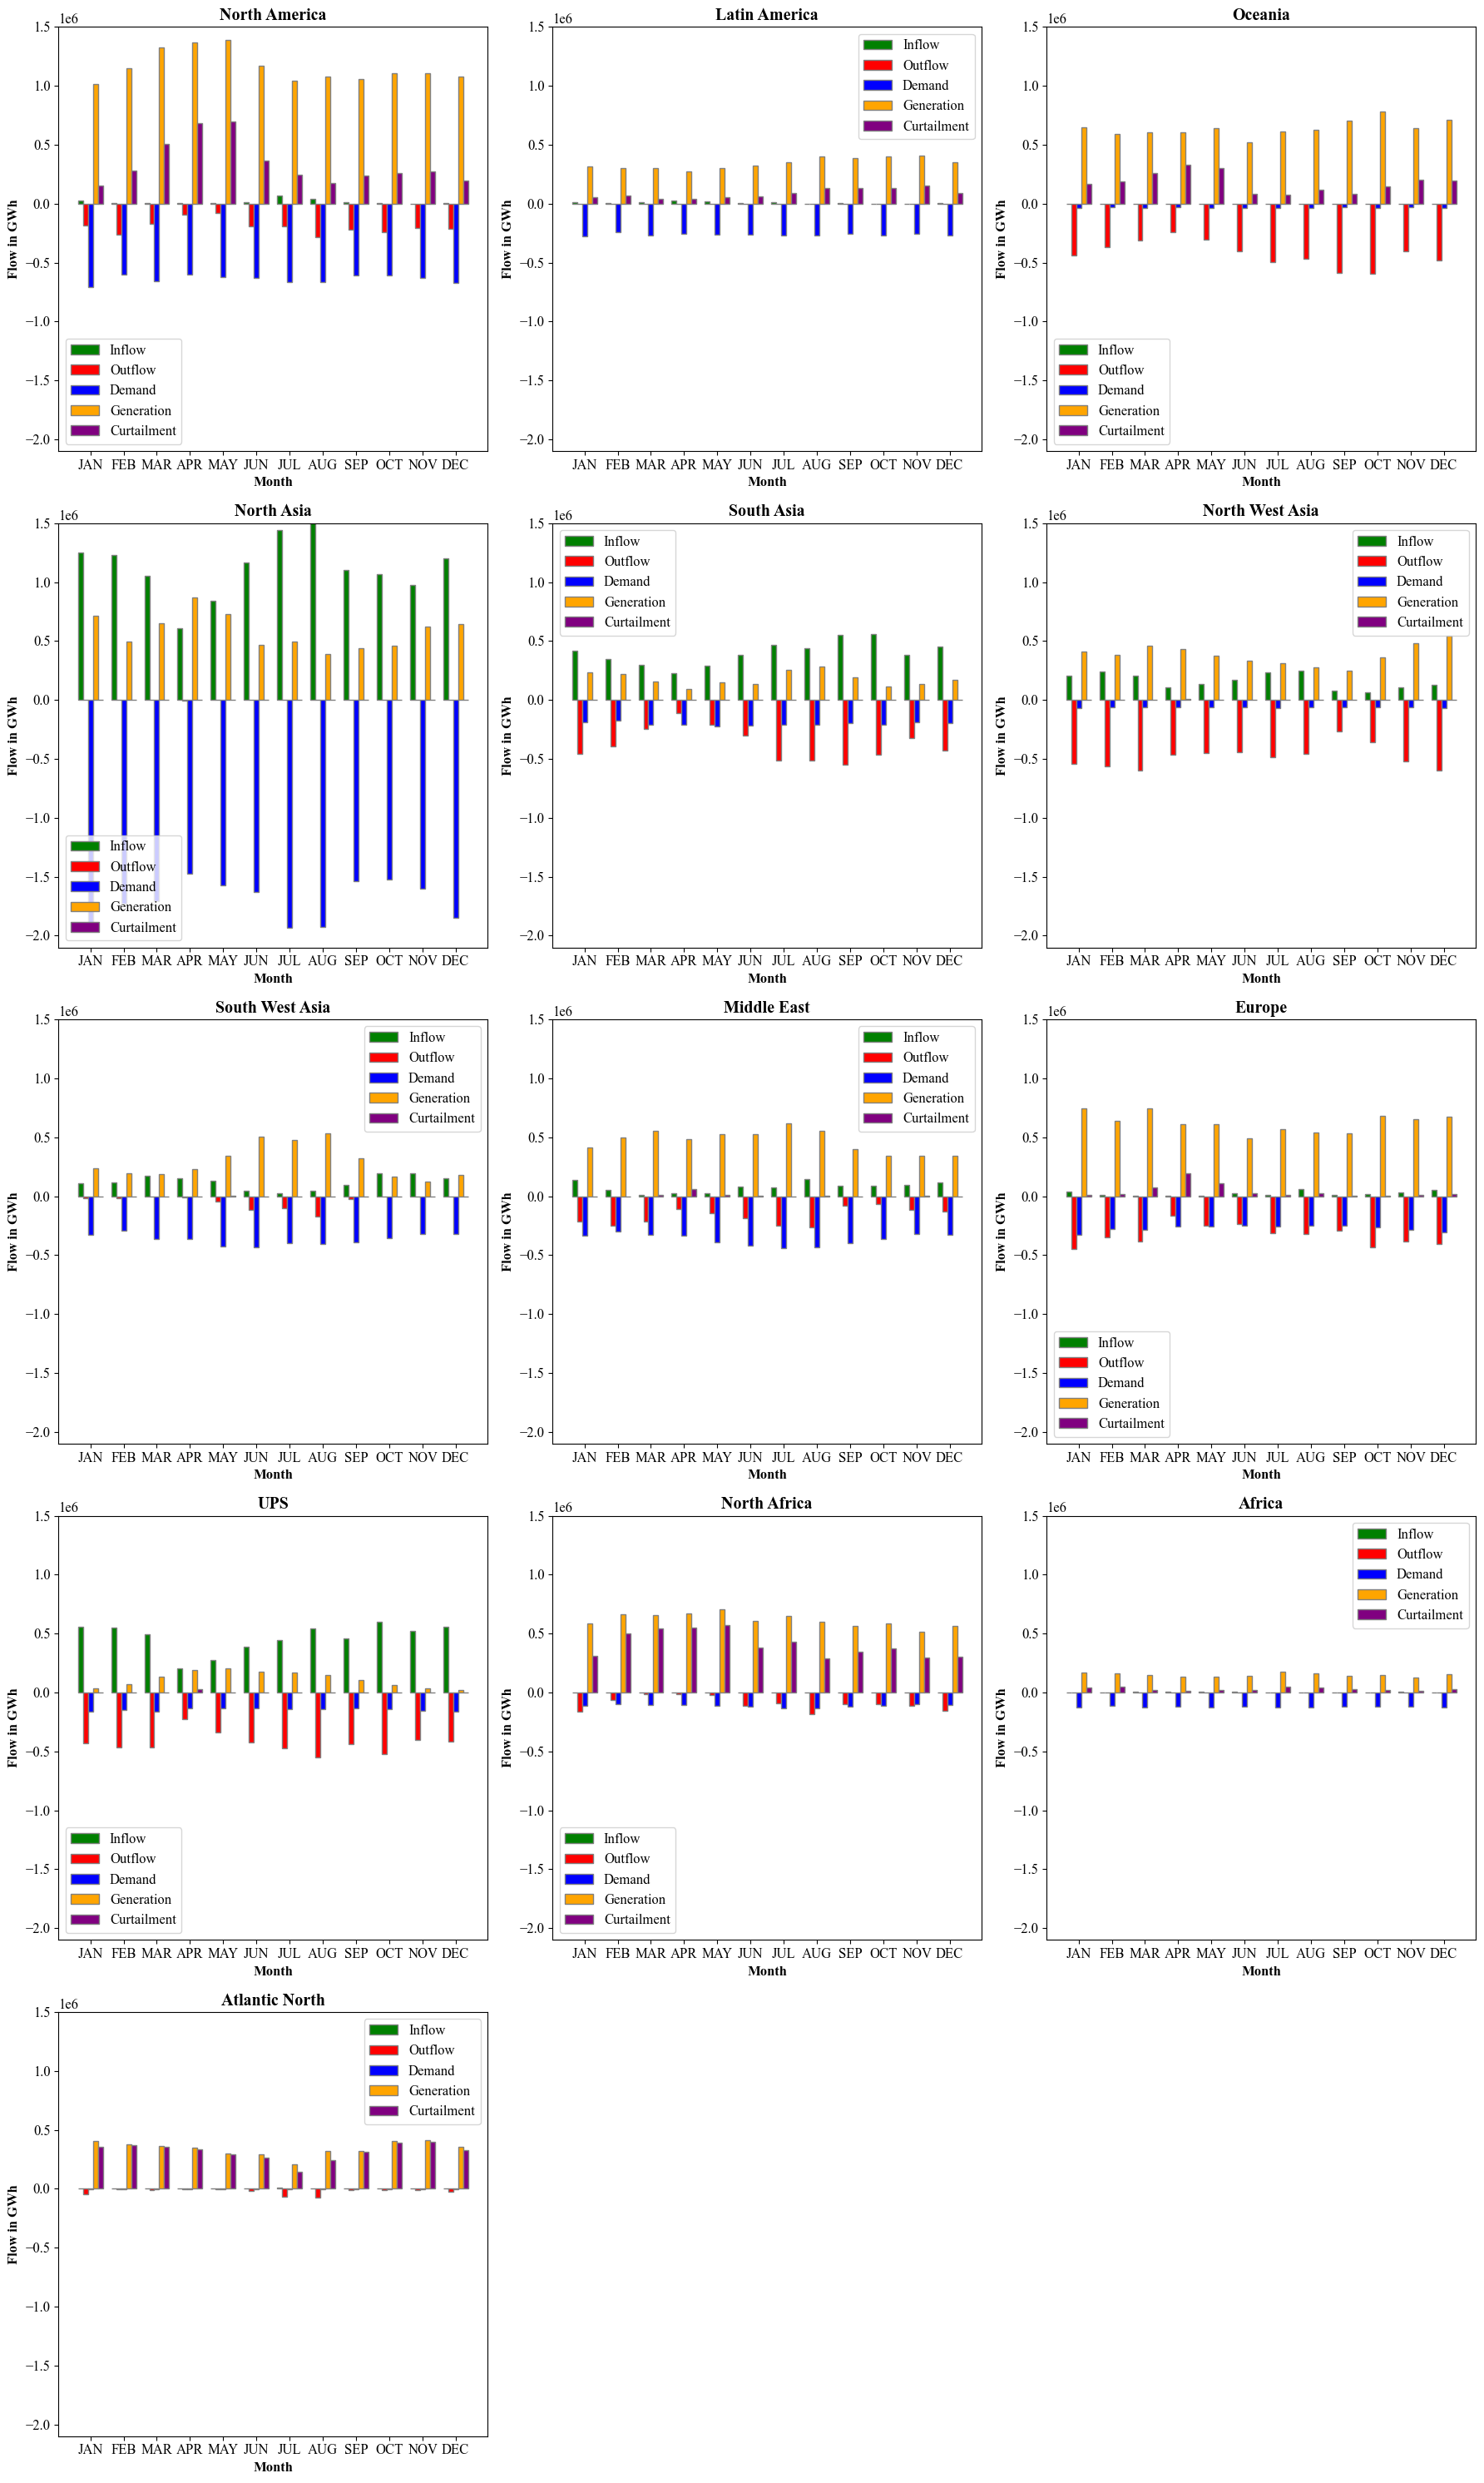

In [19]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')

def plot_region_monthly_data(region_key, region_value, ax):
    inflows = [region_value[f'inflow_{month}'] for month in months]
    outflows = [region_value[f'outflow_{month}'] for month in months]
    loads = [region_value[f'total_load_monthly'].loc[period] for period in month_periods]
    generations = [(region_value[f'total_pv_monthly'].loc[period] + region_value[f'total_wind_monthly'].loc[period]) for period in month_periods]
    curtailments = [region_value[f'total_curtailment_monthly'].loc[period] for period in month_periods]

    bar_width = 0.15
    r1 = range(len(months))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    ax.grid(False)
    ax.bar(r1, inflows, color='green', width=bar_width, edgecolor='grey', label='Inflow')
    ax.bar(r2, [-outflow for outflow in outflows], color='red', width=bar_width, edgecolor='grey', label='Outflow')
    ax.bar(r3, [-load for load in loads], color='blue', width=bar_width, edgecolor='grey', label='Demand')
    ax.bar(r4, generations, color='orange', width=bar_width, edgecolor='grey', label='Generation')
    ax.bar(r5, curtailments, color='purple', width=bar_width, edgecolor='grey', label='Curtailment')

    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Flow in GWh', fontweight='bold')
    ax.set_ylim(-2.1e6, 1.5e6)
    ax.set_title(f'{regions_dic[region_key]['region']}', fontweight='bold')
    ax.set_xticks([r + 2*bar_width for r in range(len(months))])
    ax.set_xticklabels(months)
    ax.grid(False)
    ax.legend()

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_region_monthly_data(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()


## Weekly plot

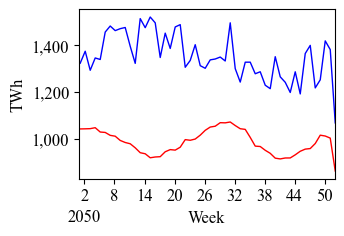

In [20]:
# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum() * 1e-6
total_weekly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('W')).sum() * 1e-6
total_weekly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('W')).sum() * 1e-6
# Remove the first entry
total_weekly_gen = total_weekly_gen.iloc[1:]
total_weekly_load = total_weekly_load.iloc[1:]
total_weekly_cur = total_weekly_cur.iloc[1:]
# Extract the week numbers and values
weeks = total_weekly_gen.index.to_timestamp()  # Convert period index to timestamp for plotting
values_gen = total_weekly_gen.values
values_load = total_weekly_load.values
values_cur = total_weekly_cur.values
total_weekly_gen.to_csv('weekly_gen_trans.csv')
# Plotting
plt.figure(figsize=(3.3, 2.2))

# Plot load on top
plt.plot(weeks, values_gen, label='Generation', linestyle='-', color='blue', linewidth=1)
plt.plot(weeks, values_load, label='Demand', linestyle='-', color='red', linewidth=1)
plt.xlabel('Week', fontsize=12)
plt.ylabel('TWh', fontsize=12)
plt.xlim(pd.Timestamp('2050-01-01'), pd.Timestamp('2050-12-25'))
plt.gca().annotate('2050', xy=(0.02, -0.23), xycoords='axes fraction', ha='center', va='center')
#plt.legend(bbox_to_anchor=(0, 0.1), loc='lower left', frameon=False)  # Add a legend to the plot

# Create a range of weeks
all_weeks = pd.date_range(start=weeks[0], periods=52, freq='W')

# Customize x-axis ticks to show every 4th week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%-U'))  # Remove leading zeros
plt.xticks(all_weeks[::6], fontsize=12)
ax = plt.gca()
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/weekly-gen-demand-line-plot.svg', format='svg')

# Show the plot
plt.show()

## Tornado plot of annual regional data

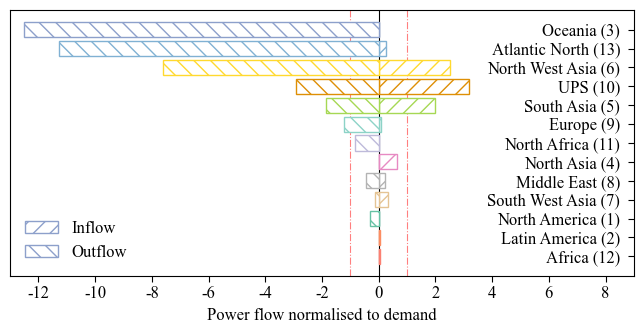

In [21]:
# Data preparation
inflow_outflow_data = [
    (region_key, region_value['inflow']/region_value['total_load_yearly'], region_value['outflow']/region_value['total_load_yearly'])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1]  for item in inflow_outflow_data]  # TWh
outflows = [item[2] for item in inflow_outflow_data]  # TWh

# Plotting the data
fig, ax = plt.subplots(figsize=(6.6, 3.5))

for i, region in enumerate(regions_inflow_outflow):
    inflow_color = region_colors[region]
    region_name = f'{regions_dic[region]['region']} ({regions_dic[region]["bus"]})'
    ax.barh(region_name, inflows[i], color='white', hatch='//', edgecolor=inflow_color, label='Inflow' if i == 0 else "", zorder=10)
    ax.barh(region_name, -outflows[i], color='white', hatch='\\\\', edgecolor=inflow_color, label='Outflow' if i == 0 else "", zorder=10)
    # ax.annotate(f'{region.replace('_', ' ').title()}', xy=(-12.1e3, i), 
    #             xycoords='data', ha='left', va='center', fontsize=12, color='black')

ax.axvline(x=0, color='black', linewidth=0.8)
ax.axvline(x=1, color='red', linewidth=0.8, linestyle='-.', zorder=1, alpha=0.5)
ax.axvline(x=-1, color='red', linewidth=0.8, linestyle='-.', zorder=1, alpha=0.5)
ax.grid(False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_xlabel('Power flow normalised to demand')
ax.set_xlim(-13, 9)
ax.legend(frameon=False, loc= 'lower left')
ax.invert_yaxis()
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.yaxis.set_ticks_position('right')

# Set y-tick labels to the right of the left axis but align them to the left
for tick_label in ax.get_yticklabels():
    tick_label.set_ha('right')  # Align horizontally to the right
    tick_label.set_position((0.97, tick_label.get_position()[1]))  # Offset the position to the right of the axis

# for tick_label, region in zip(ax.get_yticklabels(), regions_inflow_outflow):
#     tick_label.set_color(region_colors[region.lower().replace(' ', '_')])
ax.set_xticks([-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8])
ax.tick_params(axis='y', which='both', direction='in', length=4)
ax.tick_params(axis='x', which='both', direction='out', length=4)
fig.canvas.draw()
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/tornado-plot-inflows-outflows_black.svg', format='svg')

plt.show()


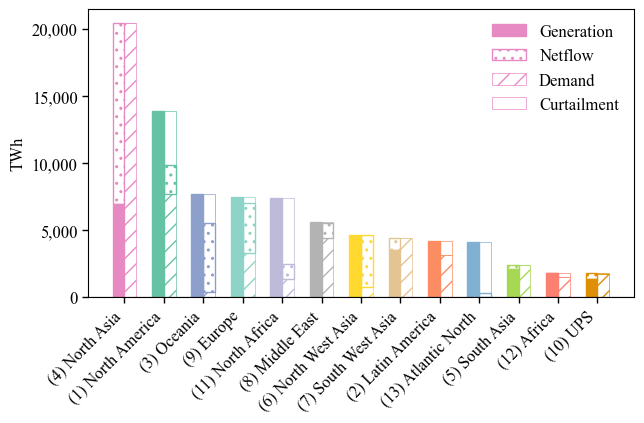

In [22]:
# Data preparation (as given)
data = [
    (region_value['region'], region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'], region_value['total_load_yearly'], region_value['inflow'], region_value['outflow'])
    for region_key, region_value in regions_dic.items()
]
data.sort(key=lambda x: max(x[1], x[2], x[3]), reverse=True)
regions = [item[0] for item in data] 
generations = [item[1] * 1e-3 for item in data] # TWh
curtailments = [item[2] * 1e-3 for item in data] # TWh
demands = [item[3] * 1e-3 for item in data] # TWh
netflows = [item[4] * 1e-3 - item[5] * 1e-3 for item in data] # TWh
# Plotting
fig, ax = plt.subplots(figsize=(6.6, 4.4))

# Bar chart for Generation and Curtailment by Region
bar_width = 0.3
x = range(len(regions))

hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Define different hatching patterns

for i, region in enumerate(regions):
    color = region_colors[region.lower().replace(' ', '_')]  # Get the color for the region from region_colors
    
    ax.bar(x[i], generations[i], bar_width, label='Generation' if i == 0 else "", color=color, edgecolor=color, align='center')
    ax.bar(x[i] if netflows[i] > 0 else x[i] + bar_width, abs(netflows[i]), bar_width,bottom=generations[i] if netflows[i] > 0 else demands[i], label='Netflow' if i == 0 else "", color='none', hatch='..', edgecolor=color,align='center')
    ax.bar(x[i] + bar_width, demands[i], bar_width, label='Demand' if i == 0 else "", color='none', edgecolor=color,hatch='//',  align='center', linewidth=0.5)
    ax.bar(x[i] + bar_width, curtailments[i], bar_width, bottom=abs(netflows[i])+demands[i] if netflows[i] < 0 else demands[i], label='Curtailment' if i == 0 else "", color='none', edgecolor=color, align='center', linewidth=0.5)
    
region_labels = [f'({regions_dic[item.lower().replace(' ', '_')]['bus']}) {item}' for i, item in enumerate(regions)] # Set x-ticks and labels
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(region_labels, rotation=45, ha='right', fontsize=12)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylabel('TWh', fontsize=12)
ax.grid(False)
ax = plt.gca()
formatter = ScalarFormatter(useMathText=False)
formatter.set_powerlimits((0, 0))  # Change the threshold for scientific notation
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
# Adjust the legend to show labels only once
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)
ax.yaxis.offsetText.set_fontsize(12)
ax.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=4, width=1, color='black')
# Adjust layout
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/bar-chart-gen-netflow-demand-cur.svg', format='svg')
plt.show()


## **Radar charts**

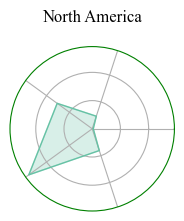

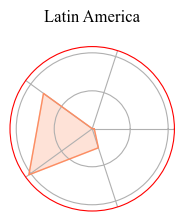

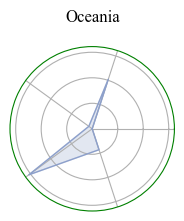

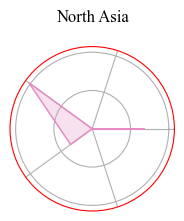

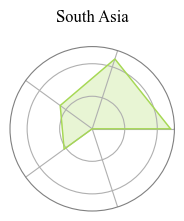

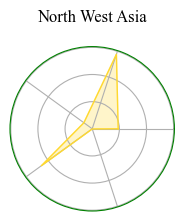

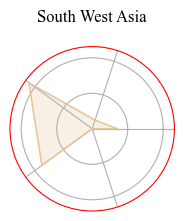

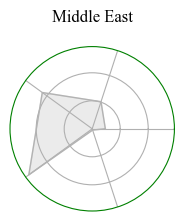

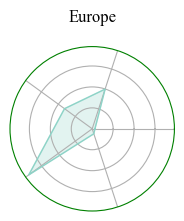

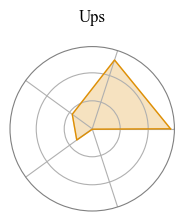

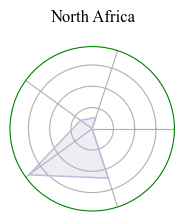

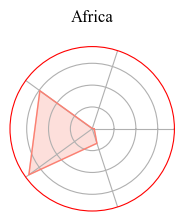

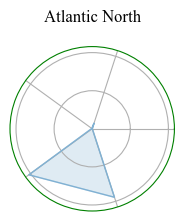

In [23]:
# Data preparation (as given)
data = {
    region_key: [
        region_value['inflow'],  # Normalize to generation
        region_value['outflow'],  # Normalize to generation
        (region_value['total_load_yearly']),  # Normalize to generation
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  # Generation normalized to itself
        region_value['total_curtailment_yearly']  # Normalize to generation
    ]
    for region_key, region_value in regions_dic.items()
}

variables = ['Inflow', 'Outflow', 'Demand', 'Generation', 'Curtailment']
df = pd.DataFrame(data, index=variables)

def plot_radar_chart(region):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    values = df[region].tolist()
    values += values[:1]
    fig, ax = plt.subplots(figsize=(2.5, 2.5), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=1, linestyle='solid', color=region_colors[region])
    ax.fill(angles, values, color=region_colors[region], alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    formatted_title = format_title(region)
    ax.set_title(formatted_title, size=12, color='black', y=1.1)
    ax.spines['polar'].set_visible(True)

    if values[0] > 4/3*values[1]:
        ax.spines['polar'].set_edgecolor('red')  # net importer
    elif values[0]*4/3 < values[1]:
        ax.spines['polar'].set_edgecolor('green') # net exporter
    else:
        ax.spines['polar'].set_edgecolor('grey') # transmission nodes


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/radar-chart-{region}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()


def format_title(title):
    return ' '.join(word.capitalize() for word in title.split('_'))

def plot_all_radar_charts():
    for region in df.columns:
        plot_radar_chart(region)

plot_all_radar_charts()


## Chord diagram of netflows 

## Demand and supply graphs of each regions

## **Stochastic analysis**

[]

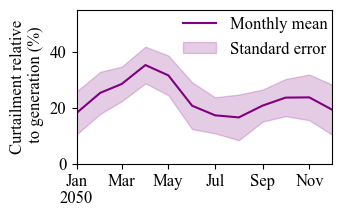

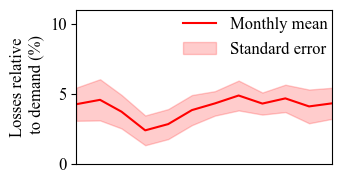

In [24]:
month_index = monthly_cur_rel_to_gen.index.to_timestamp()
mean_rel_cur_month = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.to_period('M')).mean() * 100
std_rel_cur_month = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.to_period('M')).std() * 100
mean_rel_losses_month = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.to_period('M')).mean() * 100
std_rel_losses_month = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.to_period('M')).std() * 100

plt.figure(figsize=(3.3, 2))
plt.plot(month_index, mean_rel_cur_month.values, label='Monthly mean', color='purple', linestyle='-', linewidth=1.5)
plt.fill_between(month_index, mean_rel_cur_month - std_rel_cur_month, mean_rel_cur_month + std_rel_cur_month, color='purple', alpha=0.2, label='Standard error')
plt.grid(False)
plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
          pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
plt.ylabel('Curtailment relative\n to generation (%)')
plt.ylim(0,55)
plt.legend(frameon=False,bbox_to_anchor = [1.04, 1.05], loc='upper right')

plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/monthly-relative-curtailment.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.plot()
plt.figure(figsize=(3.3, 2))
plt.plot(month_index,mean_rel_losses_month.values, label='Monthly mean', color='red', linewidth=1.5)
plt.fill_between(month_index, mean_rel_losses_month - std_rel_losses_month, mean_rel_losses_month + std_rel_losses_month, color='red', alpha=0.2, label='Standard error')
#plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
          pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
#plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xticks([])
plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
plt.grid(False)
plt.xlabel('')
plt.ylim(0,11)
plt.ylabel('Losses relative\n to demand (%)')
plt.legend(frameon=False, bbox_to_anchor = [1.04, 1.05], loc='upper right')
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/monthly-relative-losses.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.plot()


In [25]:
mean_rel_losses_month.describe()


count    12.000000
mean      4.030567
std       0.736229
min       2.403701
25%       3.822690
50%       4.293498
75%       4.395721
max       4.891737
dtype: float64

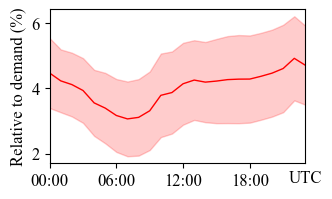

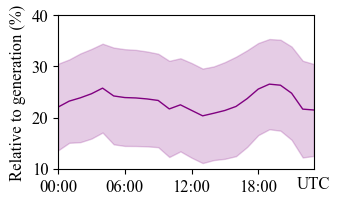

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming hourly_losses_rel_to_load and hourly_cur_rel_to_gen are defined

# Hourly losses
hourly_stats_losses = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.hour)
hourly_means_losses = hourly_stats_losses.mean() * 100
hourly_stds_losses = hourly_stats_losses.std() * 100

# Plotting
plt.figure(figsize=(3.3, 2))
plt.plot(hourly_means_losses.index, hourly_means_losses, label='Average Hourly Losses', color='red', linewidth=1)
plt.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
plt.ylabel('Relative to demand (%)')
plt.xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
plt.xlim(0, 23)
plt.grid(False)
plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/average-hourly-losses.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# Hourly curtailment
hourly_stats_cur = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.hour)
hourly_means_cur = hourly_stats_cur.mean() * 100
hourly_stds_cur = hourly_stats_cur.std() * 100

# Plotting
plt.figure(figsize=(3.3, 2))
plt.plot(hourly_means_cur.index, hourly_means_cur, label='Curtailment', color='purple', linewidth=1)
plt.fill_between(hourly_means_cur.index, hourly_means_cur - hourly_stds_cur, hourly_means_cur + hourly_stds_cur, color='purple', alpha=0.2, label='Standard error')
plt.ylabel('Relative to generation (%)')
plt.xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
plt.xlim(0, 23)
plt.yticks([10, 20, 30, 40])
plt.grid(False)
plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/average-hourly-curtailment.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


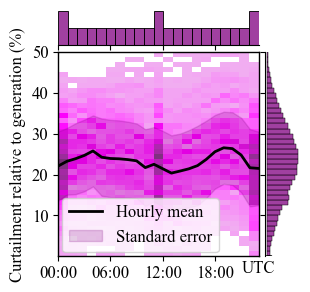

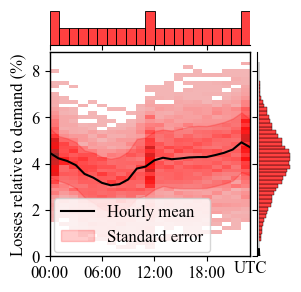

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_cur_rel_to_gen * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 3.3  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='purple')

# Add KDE to the y-axis marginal histogram
sns.kdeplot(data=df_hourly_cur_rel_to_gen['rel_cur'], ax=g.ax_marg_y, color='black', linewidth=1.5)

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove the negative ticks and labels on the top axis
g.ax_joint.xaxis.set_ticks_position('bottom')
g.ax_joint.xaxis.set_tick_params(top=False, labeltop=False)

# Plot the overlay plot on the same axis
ax = g.ax_joint
ax.plot(hourly_means_cur.index, hourly_means_cur, label='Hourly mean', color='black', linewidth=2, zorder=10)
ax.fill_between(hourly_means_cur.index, hourly_means_cur - hourly_stds_cur, hourly_means_cur + hourly_stds_cur, color='purple', alpha=0.2, label='Standard error')
ax.set_ylabel('Curtailment relative to generation (%)')
ax.set_xlabel('')
ax.set_xticks([0, 6, 12, 18])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
ax.set_ylim(0, hourly_cur_rel_to_gen_.max())
ax.set_yticks([10, 20, 30, 40, 50])
ax.grid(False)
ax.legend(loc='lower left', bbox_to_anchor= [-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')
# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/curtailment-stats.pdf', format='pdf')
plt.show()


# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_losses_rel_to_load * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 3.3  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='red')

# Add KDE to the y-axis marginal histogram
sns.kdeplot(data=df_hourly_cur_rel_to_gen['rel_cur'], ax=g.ax_marg_y, color='black', linewidth=1.5)

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove the negative ticks and labels on the top axis
g.ax_joint.xaxis.set_ticks_position('bottom')
g.ax_joint.xaxis.set_tick_params(top=False, labeltop=False)

# Plot the overlay plot on the same axis
ax = g.ax_joint
ax.plot(hourly_means_losses.index, hourly_means_losses, label='Hourly mean', color='black', linewidth=1.5)
ax.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
ax.set_ylabel('Losses relative to demand (%)')
ax.set_xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
#ax.set_ylim(0, 10)
ax.grid(False)
ax.set_xlabel('')
ax.legend(loc='lower left', bbox_to_anchor= [-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')
# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/losses-stats.pdf', format='pdf')
plt.show()


## Statistics of losses

## Correlation matrix

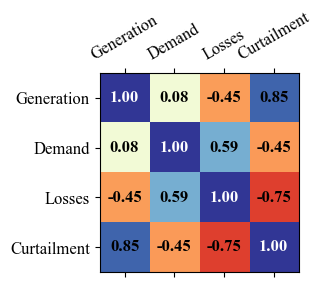

In [28]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen,
    'Demand': total_hourly_load,
    'Losses': total_hourly_abs_losses,
    'Curtailment': total_hourly_cur
    
})

# Calculate pairwise correlations
correlation_matrix = data.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(3.3, 3.3))

# Display the matrix values with reversed colormap
cax = ax.matshow(correlation_matrix, cmap='RdYlBu', vmin=-1, vmax=1)

# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns, rotation=30, fontsize=12)
ax.set_yticklabels(correlation_matrix.index, fontsize=12)

# Add text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}', ha='center', va='center', color= 'white' if i==j else 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


## Fourier Transform

### Global fourier transform

### Regional fourier transform

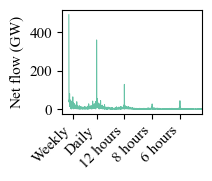

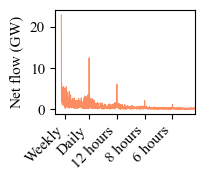

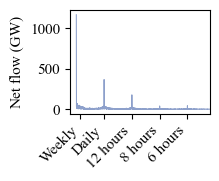

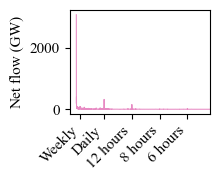

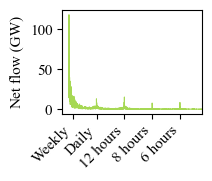

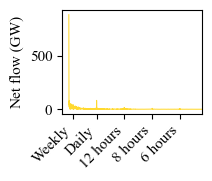

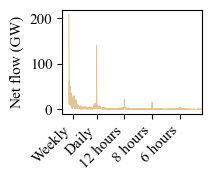

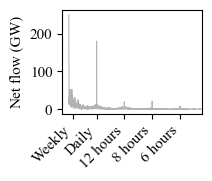

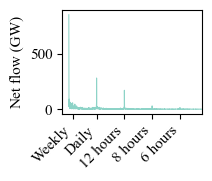

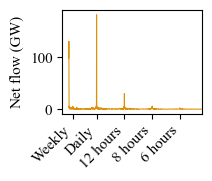

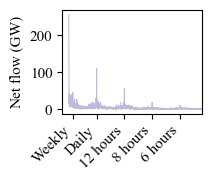

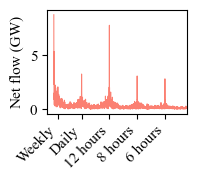

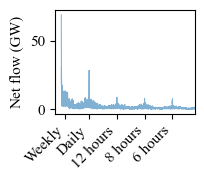

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value):
    series = region_value["netflow_series"]
    series = series.to_numpy()
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    fig_width = 1.4 # Desired x-axis length in inches
    fig_height = 1.6  # Adjust this to control overall figure height
    margins = (0.3, 0)  # Left and right margins in inches

    total_width = fig_width + margins[0] + margins[1]
    fig, ax = plt.subplots(figsize=(total_width, fig_height))

    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color=region_colors[region_key], linewidth=0.75)
    ax.set_xticks(frequencies)
    ax.set_xticklabels([])
    #ax.set_xlabel('Frequency')
    ax.set_ylabel('Net flow (GW)')
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlim(-0.01, 1/5)
    formatted_title = f'({regions_dic[region_key]["bus"]}) {format_region_name(region_key)}'
    #ax.set_title(f'{formatted_title}', fontsize=12)
    ax.grid(False)
    
    # Adjust subplot parameters to fit the axis length
    fig.subplots_adjust(left=margins[0]/total_width, right=1-margins[1]/total_width, top=0.85, bottom=0.2)
    
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/fourier-netflow-{region_key}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Loop through each region and plot individually
for region_key, region_value in regions_dic.items():
    plot_fourier_transform(region_key, region_value)


# **Maps**

## Global grid map

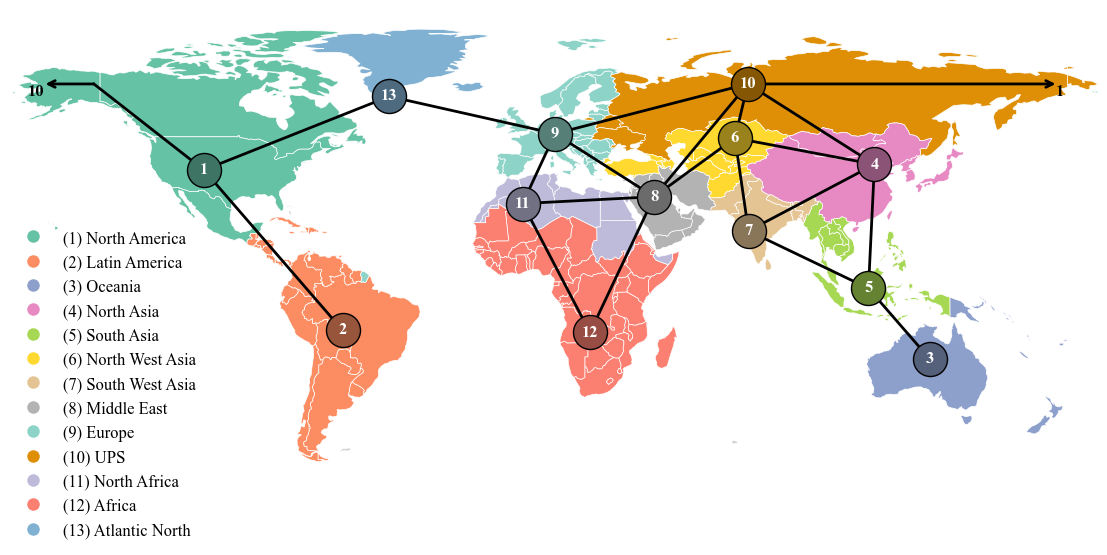

In [30]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
plt.rc("figure", figsize=(14, 10))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Manually assign French Guiana to Latin America
world.loc[world['name'] == 'France', 'bus'] = world.loc[world['name'] == 'France'].apply(
    lambda row: 'latin_america' if row['continent'] == 'South America' else row['bus'],
    axis=1
)

# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color=colors, edgecolor='white', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {regions_dic[region]['region']}')
    for i, region in enumerate(ordered_regions)
]

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=600, color=color_, edgecolor='black', zorder=5, linewidths=1, transform=ccrs.PlateCarree())
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(-165, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 177, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
ax.legend(
    handles=handles, 
    loc='lower left', 
    bbox_to_anchor=(-0.01, -0.03), 
    bbox_transform=ax.transAxes, 
    fancybox=False, 
    shadow=False, 
    ncol=1, 
    fontsize=12, 
    frameon=False, 
    framealpha=1, 
    edgecolor='black'
)
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/global-grid-map.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

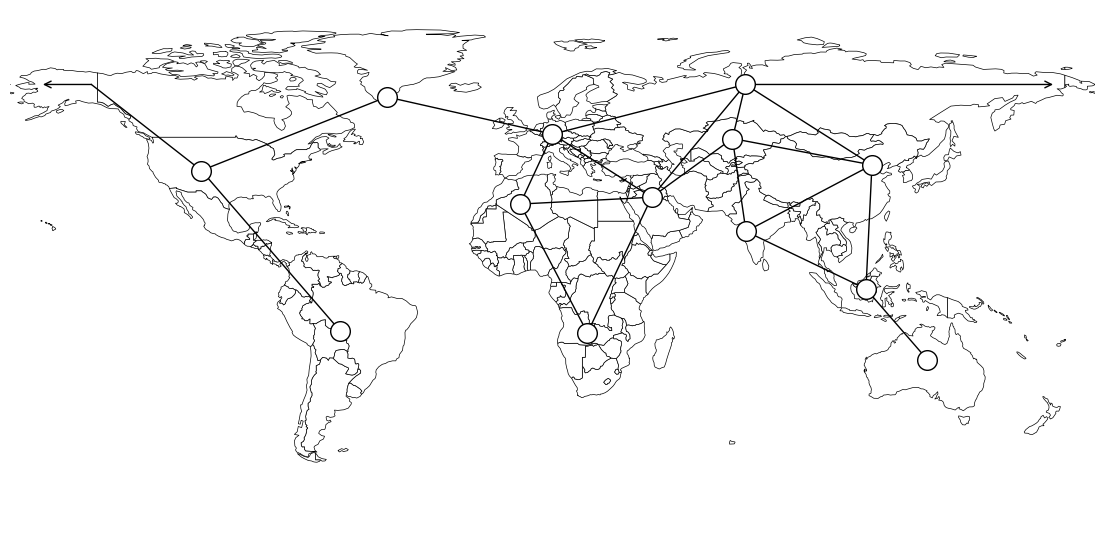

In [31]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
plt.rc("figure", figsize=(14, 10))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Manually assign French Guiana to Latin America
world.loc[world['name'] == 'France', 'bus'] = world.loc[world['name'] == 'France'].apply(
    lambda row: 'latin_america' if row['continent'] == 'South America' else row['bus'],
    axis=1
)

# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color='white', edgecolor='black', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {regions_dic[region]['region']}')
    for i, region in enumerate(ordered_regions)
]

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=200, color='white', edgecolor='black', zorder=5, linewidths=1, transform=ccrs.PlateCarree())
    #ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=1, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=1, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1), transform=ccrs.PlateCarree()) 
        #ax.text(-165, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 177, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1), transform=ccrs.PlateCarree()) 
        #ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
# ax.legend(
#     handles=handles, 
#     loc='lower left', 
#     bbox_to_anchor=(-0.01, -0.03), 
#     bbox_transform=ax.transAxes, 
#     fancybox=False, 
#     shadow=False, 
#     ncol=1, 
#     fontsize=12, 
#     frameon=False, 
#     framealpha=1, 
#     edgecolor='black'
# )
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/global-grid-map-bw.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

## Heat maps

north_america 0.2786464424151567
latin_america 0.02418081406103232
oceania 0.4877154510249544
north_asia 0.0
south_asia 0.0
north_west_asia 0.0
south_west_asia 0.0
middle_east 0.0
europe 0.5279329194658513
ups 0.05750041587171443
north_africa 0.32526068705762984
africa 0.015386769153419034
atlantic_north 0.0


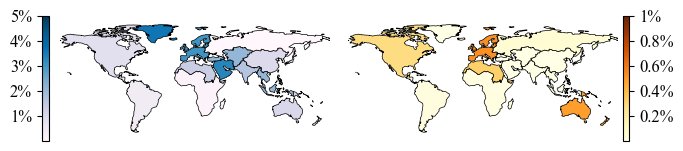

In [32]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))
wind_density = density['wind']
pv_density = density['pv']
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]
    print(key, installed_cap_pv_area[key])

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share.pdf', format='pdf', bbox_inches='tight')
plt.show()


0.8584315135522455
0.4846100953308504
1.0640506835550088
0.9834463997767227
2.0822228327156833
2.095545493031998
1.6472709871350337
3.3336477120166617
3.019269528302966
0.0
1.3656622702789591
0.15283118357286632
3.621632390094573


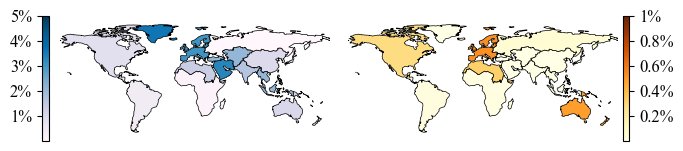

In [33]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    print(installed_cap_wind_area[key])
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Mask zero values to be white for solar generation
    # if i == 1:
    #     regions['value'] = regions['value'].apply(lambda x: np.nan if x == 0 else x)
    
    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', missing_kwds={'color': 'white'}, transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share.pdf', format='pdf', bbox_inches='tight')
plt.show()


north_america wind 8339.909828357388
north_america pv 5546.171884718525
latin_america wind 3654.0473653040017
latin_america pv 469.1694952867322
oceania wind 3435.197779346912
oceania pv 4238.947691081668
north_asia wind 6975.634841306773
north_asia pv 0.0
south_asia wind 2132.5124268841164
south_asia pv 0.0
north_west_asia wind 4625.084381777111
north_west_asia pv 0.0
south_west_asia wind 3504.7025394991206
south_west_asia pv 0.0
middle_east wind 5596.203206009966
middle_east pv 0.0
europe wind 5171.401439854036
europe pv 2321.4023350480525
ups wind 0.0
ups pv 1365.1061642643058
north_africa wind 4539.657393224016
north_africa pv 2827.15084455652
africa wind 1417.2103198506286
africa pv 375.86863924603176
atlantic_north wind 4111.03219379265
atlantic_north pv 0.0


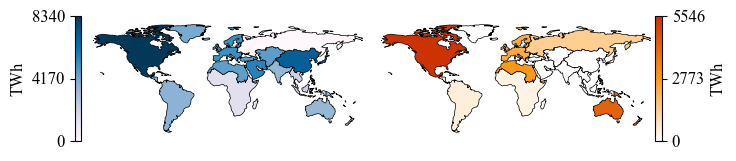

In [34]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

# Example dictionaries (Replace with actual data)
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
for key, value in regions_dic.items():
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3
    print(key, 'wind',installed_capacity_wind_dic[key])
    print(key, 'pv',installed_capacity_pv_dic[key])

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

# Create a custom colormap for solar generation with a steep gradient
colors = [(1, 1, 1), (1, 0.6, 0.1), (0.8, 0.2, 0)]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        # Set normalization with a steep gradient
        vmin = min(values_dic.values())
        vmax = max(values_dic.values())
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.PuBu if i == 0 else custom_cmap

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

        ax.spines['geo'].set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            cbar.set_ticks([0, vmax / 2, vmax])
            cbar.set_ticklabels(['0', f'{vmax / 2:.0f}', f'{vmax:.0f}'])
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.set_label('TWh')
            cbar.set_ticks([0, vmax / 2, vmax])
            cbar.set_ticklabels(['0', f'{vmax / 2:.0f}', f'{vmax:.0f}'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-gen.pdf', format='pdf', bbox_inches='tight')
plt.show()


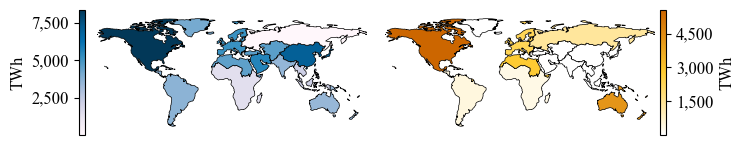

In [35]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

# Dictionary setup (example)
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
for key, value in regions_dic.items():
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

# Create a custom colormap for the solar generation
colors = [(1, 1, 1), (1, 0.8, 0.2), (0.8, 0.4, 0)]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
        cmap = cm.PuBu if i == 0 else custom_cmap

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)
        vmin = min(values_dic.values())
        vmax = max(values_dic.values())
        # if i == 1:
        #     zero_gen = regions[regions['value'] == 0]
            #zero_gen.plot(ax=ax, facecolor="none", edgecolor="black", hatch='xx', transform=ccrs.PlateCarree(), linewidth=0.5)

        ax.spines['geo'].set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            cbar.set_ticks([2500, 5000, 7500])
            cbar.set_ticklabels(['2,500', '5,000', '7,500'])
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.set_label('TWh')
            cbar.set_ticks([1500, 3000, 4500])
            cbar.set_ticklabels(['1,500', '3,000', '4,500'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-gen.pdf', format='pdf', bbox_inches='tight')
plt.show()


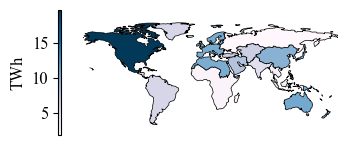

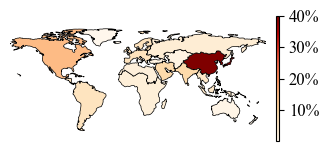

In [36]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

total_generation_global_share = {}
demand_global_share = {}
global_load = 0
global_generation = 0
for key, value in regions_dic.items():
    global_load += value["total_load_yearly"] 
    global_generation += (value["total_wind_yearly"] + value["total_pv_yearly"])
for key, value in regions_dic.items():
    area = region_area(key)
    total_generation_global_share[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / global_generation * 100
    demand_global_share[key] = value["total_load_yearly"] / global_load * 100
values_dics = [total_generation_global_share,  demand_global_share]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(4, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Create a custom colormap for the solar generation
colors = [(1, 1, 1), (1, 0.8, 0), (1, 0, 0), (0.5, 0, 0)]  # white -> yellow -> red -> deep red
n_bins = 100  # Discretizes the interpolation into bins
deep_red_cmap = LinearSegmentedColormap.from_list('deep_red_cmap', colors, N=n_bins)

for i, values_dic in enumerate(values_dics):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(3.3, 2.5))
    
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
        cmap = cm.PuBu if i == 0 else cm.OrRd

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)
        
        ax.spines['geo'].set_visible(False)
        vmax = max(values_dic.values())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            # cbar.set_ticks([2500, 5000, 7500])
            # cbar.set_ticklabels(['2,500', '5,000', '7,500'])
            #plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-gen.pdf', format='pdf', bbox_inches='tight')
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            #cbar.set_label('TWh')
            cbar.set_ticks([10, 20, 30, 40])
            cbar.set_ticklabels(['10%','20%', '30%', '40%'])
            plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-demand.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()


north_america 5546.171884718525
latin_america 469.1694952867322
oceania 4238.947691081668
north_asia 0.0
south_asia 0.0
north_west_asia 0.0
south_west_asia 0.0
middle_east 0.0
europe 2321.4023350480525
ups 1365.1061642643058
north_africa 2827.15084455652
africa 375.86863924603176
atlantic_north 0.0


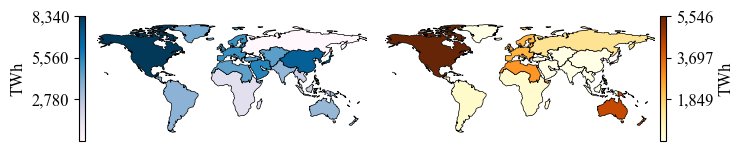

In [37]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3 
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3
    print(key, installed_capacity_pv_dic[key])
values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]
def comma_formatter(x, pos):
    return '{:,.0f}'.format(x)
warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))


# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed
    vmin = min(values_dic.values())
    vmax = max(values_dic.values())
    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu if i == 0 else cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)
    vmax = max(values_dic.values())
    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_label('TWh')
        #cbar.set_ticks([2500, 5000, 7500])
        cbar.set_ticks([vmax/3, vmax * 2/3, vmax])
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))
        #cbar.set_ticklabels(['2,500', '5,000', '7,500'])
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_label('TWh')
        #cbar.set_ticks([1500, 3000, 4500])
        cbar.set_ticks([vmax/3, vmax * 2/3, vmax])
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))
        #cbar.set_ticklabels(['1,500', '3,000', '4,500'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-pv-gen-global-share.svg', format='svg')
plt.show()

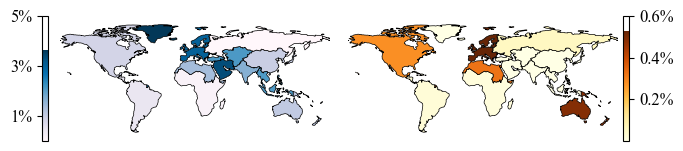

In [38]:
warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu if i == 0 else cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1,  3, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '3%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-pv-land-use.svg', format='svg')
plt.show()

## Power flow chart

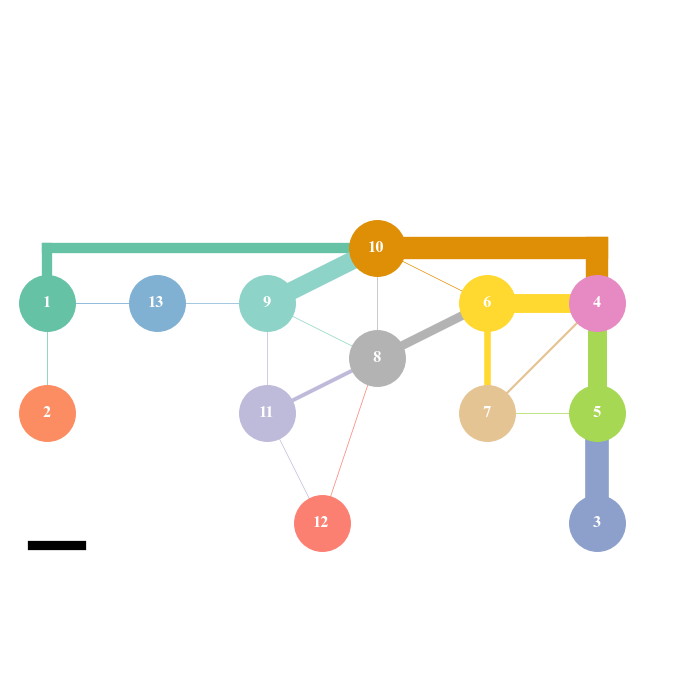

In [39]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1600, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.3e9, 0.5)

    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Add a reference line for 2,000 TWh
reference_line_width = 2000e6 / 0.3e9  # Convert TWh to the same scale used for linewidth calculation
ax.plot([-3.2 * scale, -3.2 * scale + 1], [-1.8 * scale, -1.8 * scale], color='black', linewidth=reference_line_width)
#ax.text(-3.1 * scale + 1.1, -1.8 * scale, '2,000 TWh', color='black', fontsize=12, va='center')

# Remove axes for a cleaner look
ax.set_axis_off()

# Adjust layout to remove extra whitespace
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save figure with tight bounding box
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()


# **Availability of VRE**

# Temporal availability

## Scatter plot of supply over demand 

In [40]:
demand = 0
supply = 0
for key, value in regions_dic.items():
    demand += n.loads_t.p[f'load_{key}'] * 1e-3 #GW
    supply += (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}']) * 1e-3 
demand_supply_ratio = supply / demand
demand_supply_ratio_no_trans = pd.read_csv('demand_supply_ratio.csv', index_col=0)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(demand_supply_ratio.index, demand_supply_ratio.values, s=0.3, color='brown', alpha=0.3)
ax.scatter(demand_supply_ratio.index, demand_supply_ratio_no_trans.values, s=0.3, color='blue', alpha=0.3)
ax.axhline(y=1, color='green', linewidth=1, linestyle='--')
ax.grid(False)
ax.set_ylabel('(-)', fontsize=12)
#ax.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'demand_supply_ratio.csv'

# **Curtailment**

## Scatter plot global

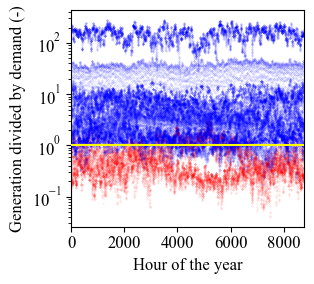

85.09132420091325 92.59132420091325


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
net_importer = ['north_asia', 'south_west_asia']#, 'latin_america', 'africa']
net_exporter = ['oceania', 'north_west_asia', 'europe','north_america','middle_east','north_africa', 'atlantic_north']
demand_net_importer = 0 
supply_net_importer = 0
demand_net_exporter = 0
supply_net_exporter = 0


#share_ex = (demand_supply_ratio_ex > 1).sum() / 8760 * 100
share_im = 0
fig, ax = plt.subplots(figsize=(3.3, 3))
#for key in net_importer:
for key in net_importer:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    demand_supply_ratio_im = supply_net_importer / demand_net_importer
    scatter_im = ax.scatter(demand_supply_ratio_im.index, demand_supply_ratio_im.values, s=0.07, color='red', alpha=0.2)
    share_im += (demand_supply_ratio_im < 1).sum() / 8760 * 100
share_im = share_im / len(net_importer)
share_ex = 0
for key in net_exporter:
    demand_net_exporter = n.loads_t.p[f'load_{key}'] 
    supply_net_exporter = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    demand_supply_ratio_ex = supply_net_exporter / demand_net_exporter
    scatter_ex = ax.scatter(demand_supply_ratio_ex.index, demand_supply_ratio_ex.values, s=0.07, color='blue', alpha=0.2)
    share_ex += (demand_supply_ratio_ex > 1).sum() / 8760 * 100
share_ex = share_ex / len(net_exporter)
ax.axhline(y=1, color='yellow', linewidth=1.5, linestyle='-', label='Supply = Demand', zorder=10)

ax.grid(False)
ax.set_ylabel('Generation divided by demand (-)', fontsize=12)
ax.set_xlabel('Hour of the year')
ax.set_xlim(demand_supply_ratio_im.index[0], demand_supply_ratio_im.index[-1])
# Calculate the number of hours in the year and set x-ticks at every full 1000-hour interval
num_hours = len(demand_supply_ratio_im.index)
ticks_to_use = np.arange(0, num_hours, 2000)

# Extract the timestamps for the ticks
timestamps = demand_supply_ratio_im.index[ticks_to_use]

# Create labels as hours of the year
tick_labels = [str(i) for i in ticks_to_use]

ax.set_xticks(timestamps)
ax.set_xticklabels(tick_labels)
ax.set_yscale('log')
plt.tight_layout()
#plt.legend(fontsize=12, frameon=True, loc='lower left', bbox_to_anchor=[-0.025, -0.025]) # handles=[scatter_im, scatter_ex], scatterpoints=1, markerscale=10,
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/scatter-plot.svg', format='svg')
plt.show()
print(share_im, share_ex)


In [80]:
# Plotting 
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

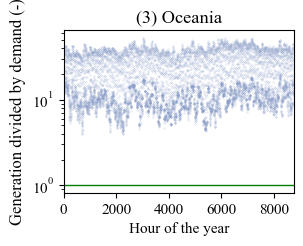

Demand deficit: 0h - 0.0%
Export: 8521h
Export: 0.972716894977169%
Export of surplus: 97.27168949771689%
Curtails: 46.438356164383556%
Curtailment: 4068h


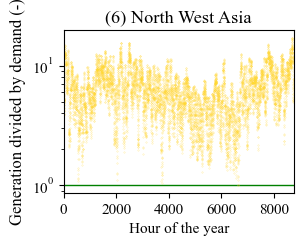

Demand deficit: 1h - 0.01%
Export: 8759h
Export: 0.9998858447488584%
Export of surplus: 100.0%
Curtails: 0.822011645164973%
Curtailment: 72h


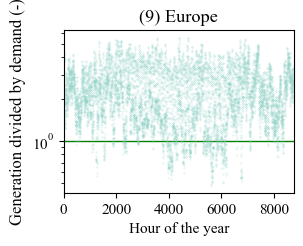

Demand deficit: 658h - 7.51%
Export: 7947h
Export: 0.9071917808219178%
Export of surplus: 98.08689212540114%
Curtails: 16.99580350530733%
Curtailment: 1377h


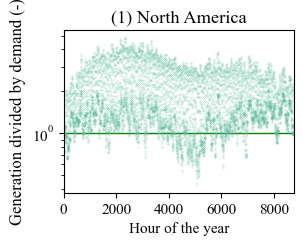

Demand deficit: 1062h - 12.12%
Export: 5376h
Export: 0.6136986301369863%
Export of surplus: 69.83632112236945%
Curtails: 78.78669784359575%
Curtailment: 6065h


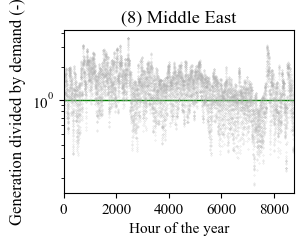

Demand deficit: 2822h - 32.21%
Export: 6647h
Export: 0.7587899543378995%
Export of surplus: 111.94004715392387%
Curtails: 5.658470865611317%
Curtailment: 336h


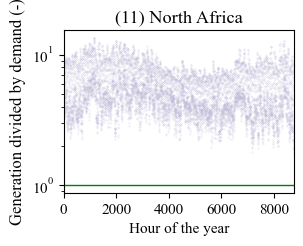

Demand deficit: 0h - 0.0%
Export: 4985h
Export: 0.5690639269406392%
Export of surplus: 56.906392694063925%
Curtails: 94.2351598173516%
Curtailment: 8255h


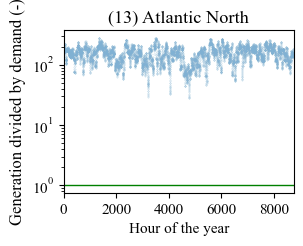

Demand deficit: 0h - 0.0%
Export: 1663h
Export: 0.18984018264840183%
Export of surplus: 18.984018264840184%
Curtails: 97.75114155251141%
Curtailment: 8563h


In [86]:
net_exporter = ['oceania', 'north_west_asia', 'europe','north_america','middle_east','north_africa', 'atlantic_north']
fig_width = 2.3 # Desired x-axis length in inches
fig_height = 2.5  # Adjust this to control overall figure height
margins = (0.6, 0.05)  # Left and right margins in inches
for key in net_exporter:
    total_width = fig_width + margins[0] + margins[1]
    fig, ax = plt.subplots(figsize=(total_width, fig_height))
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    export = regions_dic[key]['outflow_series']
    curtailment = n.generators_t.p[f'curtailment_{key}']
    demand_supply_ratio_im = supply_net_importer / demand_net_importer
    hours_in_deficit = (demand_supply_ratio_im < 1).sum()
    hours_export = (export > 0).sum()
    hours_curtailment = (curtailment > 0).sum()
    share_im = hours_in_deficit / 8760 * 100
    ax.axhline(y=1, color='green', linewidth=1, linestyle='-', zorder=1)
    scatter_im = ax.scatter(demand_supply_ratio_im.index, demand_supply_ratio_im.values, s=0.05, color=region_colors[key], alpha=0.6)
 
    ax.grid(False)
    ax.set_title(f'({regions_dic[key]['bus']}) {regions_dic[key]['region']}')
    ax.set_ylabel('Generation divided by demand (-)', fontsize=12)
    ax.set_xlabel('Hour of the year')
    ax.set_yscale('log')
    ax.set_xlim(demand_supply_ratio_im.index[0], demand_supply_ratio_im.index[-1])
    # Calculate the number of hours in the year and set x-ticks at every full 1000-hour interval
    num_hours = len(demand_supply_ratio_im.index)
    ticks_to_use = np.arange(0, num_hours, 2000)

    # Extract the timestamps for the ticks
    timestamps = demand_supply_ratio_im.index[ticks_to_use]

    # Create labels as hours of the year
    tick_labels = [str(i) for i in ticks_to_use]

    ax.set_xticks(timestamps)
    ax.set_xticklabels(tick_labels)
    fig.subplots_adjust(left=margins[0]/total_width, right=1-margins[1]/total_width, top=0.85, bottom=0.2)

    #plt.legend(fontsize=12, frameon=True, loc='lower left', bbox_to_anchor=[-0.025, -0.025]) # handles=[scatter_im, scatter_ex], scatterpoints=1, markerscale=10,
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/scatter-plot-{key}.svg', format='svg')
    plt.show()
    print(f'Demand deficit: {hours_in_deficit}h - {round(share_im,2)}%')
    print(f'Export: {hours_export}h')
    print(f'Export: {hours_export/8760}%')
    print(f'Export of surplus: {hours_export / (8760 - hours_in_deficit)*100}%')
    print(f'Curtails: {hours_curtailment / (8760 - hours_in_deficit)*100}%')

    print(f'Curtailment: {hours_curtailment}h')


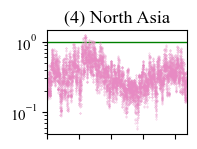

Demand deficit: 8724h - 99.59%
Export: 33h
Export: 91.66666666666666%
Curtailment: 26h


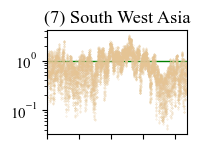

Demand deficit: 6184h - 70.59%
Export: 2564h
Export: 99.53416149068323%
Curtailment: 16h


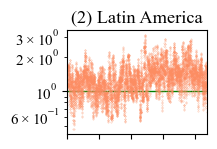

Demand deficit: 1873h - 21.38%
Export: 128h
Export: 1.8585741251633512%
Curtailment: 6853h


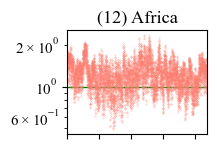

Demand deficit: 2066h - 23.58%
Export: 191h
Export: 2.8533014639976098%
Curtailment: 6532h


In [79]:
net_importer = ['north_asia', 'south_west_asia', 'latin_america', 'africa']
fig_width = 1.4 # Desired x-axis length in inches
fig_height = 1.6  # Adjust this to control overall figure height
margins = (0.6, 0.05)  # Left and right margins in inches
for key in net_importer:
    total_width = fig_width + margins[0] + margins[1]
    fig, ax = plt.subplots(figsize=(total_width, fig_height))
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    export = regions_dic[key]['outflow_series']
    curtailment = n.generators_t.p[f'curtailment_{key}']
    demand_supply_ratio_im = supply_net_importer / demand_net_importer
    hours_in_deficit = (demand_supply_ratio_im < 1).sum()
    hours_export = (export > 0).sum()
    hours_curtailment = (curtailment > 0).sum()
    share_im = hours_in_deficit / 8760 * 100
    ax.axhline(y=1, color='green', linewidth=1, linestyle='-', zorder=1)
    scatter_im = ax.scatter(demand_supply_ratio_im.index, demand_supply_ratio_im.values, s=0.07, color=region_colors[key], alpha=0.6)
 
    ax.grid(False)
    ax.set_title(f'({regions_dic[key]['bus']}) {regions_dic[key]['region']}')
    #ax.set_ylabel('Generation divided by demand (-)', fontsize=12)
    #ax.set_xlabel('Hour of the year')
    ax.set_yscale('log')
    ax.set_xlim(demand_supply_ratio_im.index[0], demand_supply_ratio_im.index[-1])
    # Calculate the number of hours in the year and set x-ticks at every full 1000-hour interval
    num_hours = len(demand_supply_ratio_im.index)
    ticks_to_use = np.arange(0, num_hours, 2000)

    # Extract the timestamps for the ticks
    timestamps = demand_supply_ratio_im.index[ticks_to_use]

    # Create labels as hours of the year
    tick_labels = [str(i) for i in ticks_to_use]

    ax.set_xticks(timestamps)
    ax.set_xticklabels([])
    fig.subplots_adjust(left=margins[0]/total_width, right=1-margins[1]/total_width, top=0.85, bottom=0.2)
    #plt.legend(fontsize=12, frameon=True, loc='lower left', bbox_to_anchor=[-0.025, -0.025]) # handles=[scatter_im, scatter_ex], scatterpoints=1, markerscale=10,
    #
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/scatter-plot-{key}.svg', format='svg')
    plt.show()
    print(f'Demand deficit: {hours_in_deficit}h - {round(share_im,2)}%')
    print(f'Export: {hours_export}h')
    print(f'Export: {hours_export / (8760 - hours_in_deficit)*100}%')
    print(f'Curtailment: {hours_curtailment}h')


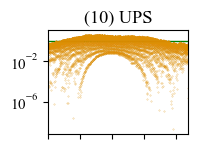

Demand deficit: 6021h - 68.73%
Export: 8300h
Export: 0.9474885844748858%
Export of surplus: 303.030303030303%
Curtails: 5.695509309967141%
Curtailment: 156h


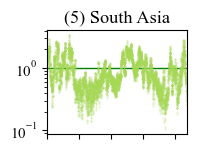

Demand deficit: 5986h - 68.33%
Export: 7776h
Export: 0.8876712328767123%
Export of surplus: 280.31723143475125%
Curtails: 0.03604902667627974%
Curtailment: 1h


In [78]:
hubs = ['ups', 'south_asia']
fig_width = 1.4 # Desired x-axis length in inches
fig_height = 1.6  # Adjust this to control overall figure height
margins = (0.6, 0.05)  # Left and right margins in inches
for key in hubs:
    fig, ax = plt.subplots(figsize=(total_width, fig_height))
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    export = regions_dic[key]['outflow_series']
    curtailment = n.generators_t.p[f'curtailment_{key}']
    demand_supply_ratio_im = supply_net_importer / demand_net_importer
    hours_in_deficit = (demand_supply_ratio_im < 1).sum()
    hours_export = (export > 0).sum()
    hours_curtailment = (curtailment > 0).sum()
    share_im = hours_in_deficit / 8760 * 100
    ax.axhline(y=1, color='green', linewidth=1, linestyle='-', zorder=1)
    scatter_im = ax.scatter(demand_supply_ratio_im.index, demand_supply_ratio_im.values, s=0.07, color=region_colors[key], alpha=0.6)
 
    ax.grid(False)
    #ax.set_title(f'{key}')
    #ax.set_ylabel('Generation divided by demand (-)', fontsize=12)
    #ax.set_xlabel('Hour of the year')
    ax.set_title(f'({regions_dic[key]['bus']}) {regions_dic[key]['region']}')
    ax.set_yscale('log')
    ax.set_xlim(demand_supply_ratio_im.index[0], demand_supply_ratio_im.index[-1])
    # Calculate the number of hours in the year and set x-ticks at every full 1000-hour interval
    num_hours = len(demand_supply_ratio_im.index)
    ticks_to_use = np.arange(0, num_hours, 2000)

    # Extract the timestamps for the ticks
    timestamps = demand_supply_ratio_im.index[ticks_to_use]

    # Create labels as hours of the year
    tick_labels = [str(i) for i in ticks_to_use]

    ax.set_xticks(timestamps)
    ax.set_xticklabels([])
    fig.subplots_adjust(left=margins[0]/total_width, right=1-margins[1]/total_width, top=0.85, bottom=0.2)
    #plt.legend(fontsize=12, frameon=True, loc='lower left', bbox_to_anchor=[-0.025, -0.025]) # handles=[scatter_im, scatter_ex], scatterpoints=1, markerscale=10,
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/scatter-plot-{key}.svg', format='svg')
    plt.show()
    print(f'Demand deficit: {hours_in_deficit}h - {round(share_im,2)}%')
    print(f'Export: {hours_export}h')
    print(f'Export: {hours_export/8760}%')
    print(f'Export of surplus: {hours_export / (8760 - hours_in_deficit)*100}%')
    print(f'Curtails: {hours_curtailment / (8760 - hours_in_deficit)*100}%')

    print(f'Curtailment: {hours_curtailment}h')


## Correlation Matrix of VRE potentials vs Demand 

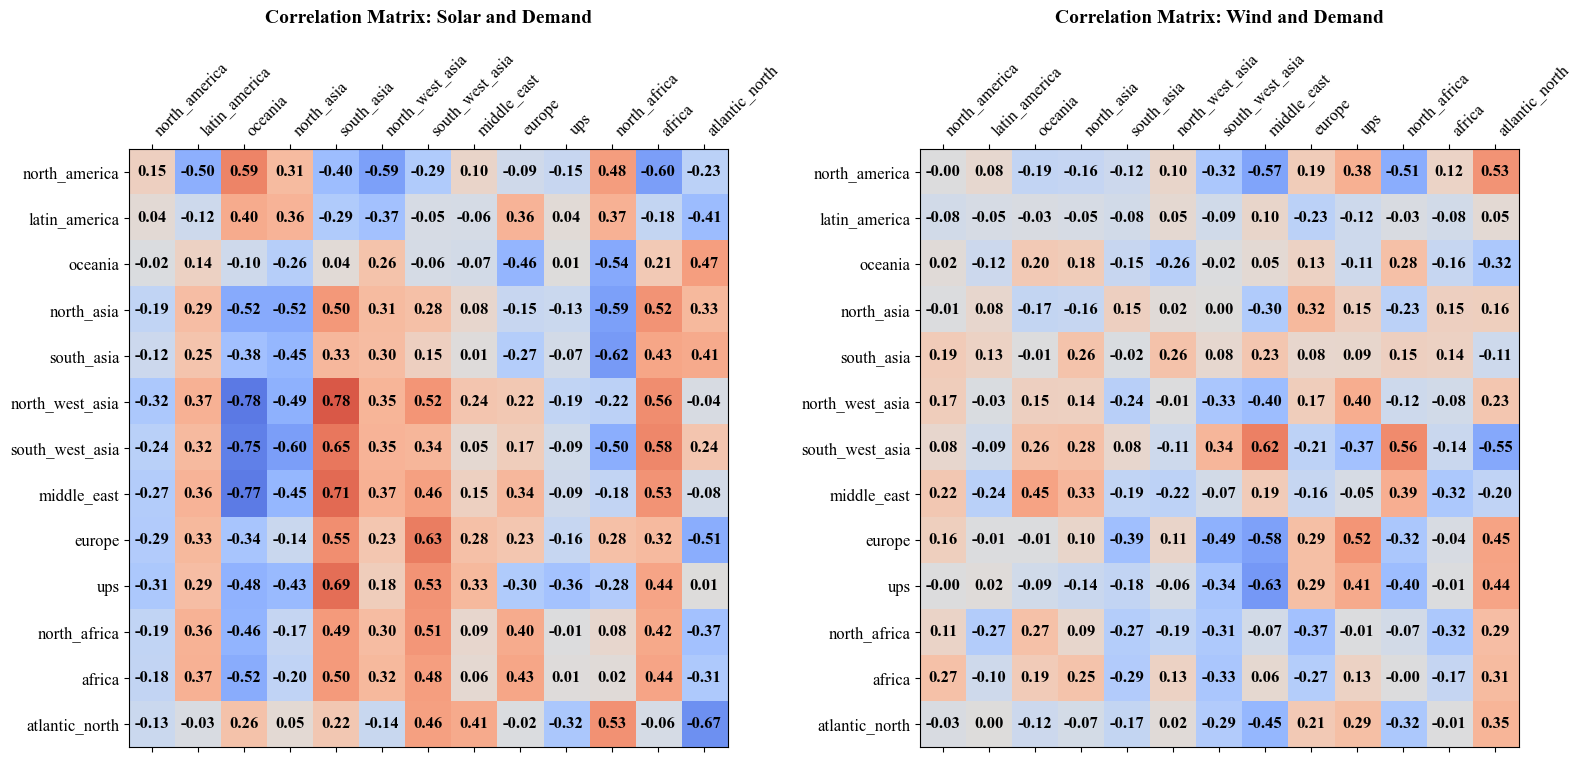

In [ ]:
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})


regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        correlation_matrix1.loc[i, j] = data1[i].corr(demand[j])
        correlation_matrix2.loc[i, j] = data2[i].corr(demand[j])

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()


/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



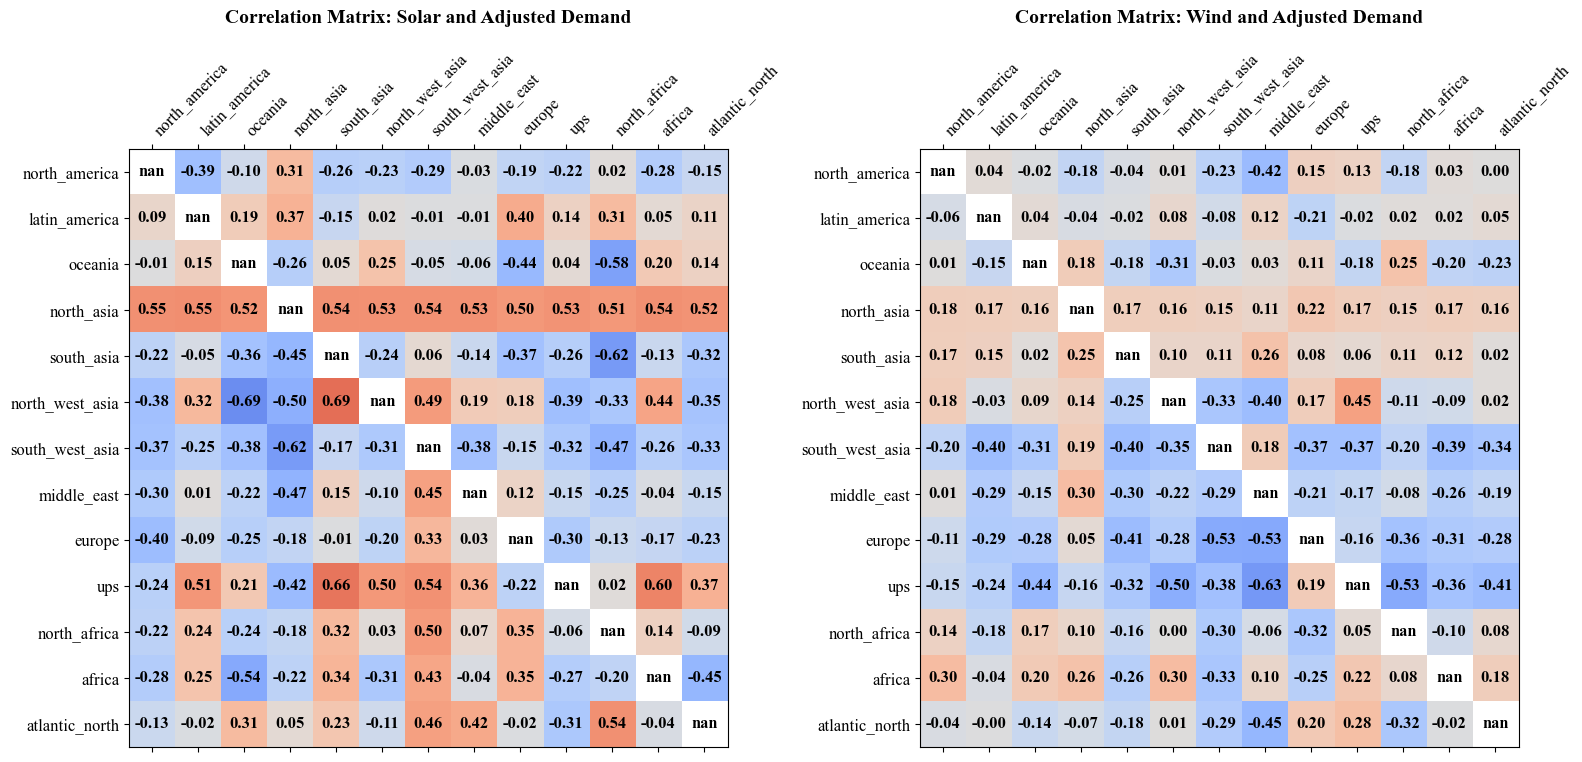

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})

regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        adjusted_demand_j = demand[j] - demand[i]
        correlation_matrix1.loc[i, j] = data1[i].corr(adjusted_demand_j)
        correlation_matrix2.loc[i, j] = data2[i].corr(adjusted_demand_j)

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})
generation = pd.DataFrame({key: n.generators_t.p[f'wind_{key}'] for i, (key, value) in enumerate(regions_dic.items())})
regions = list(regions_dic.keys())
num_regions = len(regions)

# Initialize the R-squared matrix
r_squared_matrix = np.zeros((num_regions, num_regions))

# Loop through each region's demand and each region's PV and wind
for i, region_demand in enumerate(regions):

    for j, region_generation in enumerate(regions):
        y = demand[region_demand].values - demand[region_generation].values
        X = np.vstack([data1[region_generation].values, data2[region_generation].values, data1[region_demand].values, data2[region_demand].values]).T
        model = LinearRegression().fit(X, y)
        r_squared = model.score(X, y)
        r_squared_matrix[j, i] = r_squared

# Convert R-squared matrix to DataFrame for better readability
r_squared_df = pd.DataFrame(r_squared_matrix, index=regions, columns=regions)

# Plot the R-squared matrix
fig, ax = plt.subplots(figsize=(6.6, 6.6))

# Display the matrix values with reversed colormap
cax = ax.matshow(r_squared_df, cmap='PuBu', vmin=0, vmax=1)
index = r_squared_df.columns
labels = [label.replace('_', ' ').title() for label in index]
# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(r_squared_df.columns)))
ax.set_yticks(range(len(r_squared_df.index)))
ax.set_xticklabels(labels, rotation=45, fontsize=12, ha='left')
ax.set_yticklabels(labels, fontsize=12)

# Add text annotations
for i in range(len(r_squared_df.columns)):
    for j in range(len(r_squared_df.index)):
        if i != j:
            plt.text(i, j, f'{r_squared_df.iloc[j, i]:.2f}', ha='center', va='center', color= 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
#plt.title('R-squared Matrix: PV & Wind Generation vs. Demand', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix-vre-demand.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


NameError: name 'regions_dic' is not defined

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_7440/2415676019.py:26: RuntimeWarning:

invalid value encountered in scalar divide



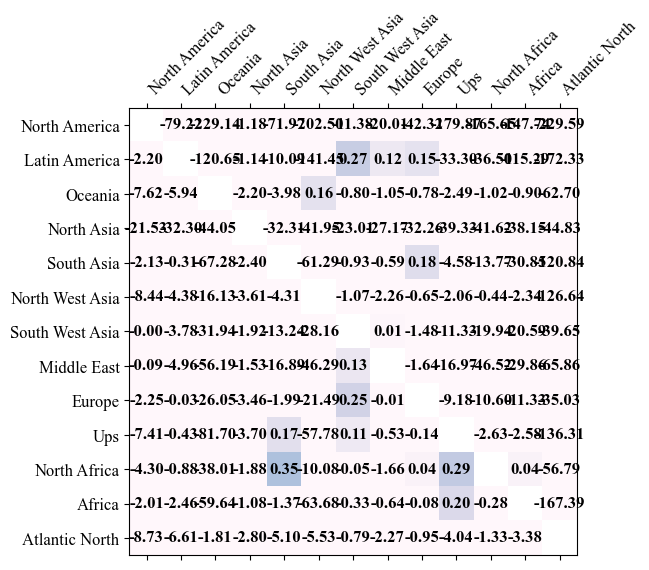

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})
regions = list(regions_dic.keys())
num_regions = len(regions)

# Initialize the R-squared matrix
r_squared_matrix = np.zeros((num_regions, num_regions))

# Loop through each region's demand and each region's PV and wind
for i, region_demand in enumerate(regions):
    for j, region_generation in enumerate(regions):
        y = demand[region_demand].values - demand[region_generation].values
        X = np.vstack([data1[region_generation].values, data2[region_generation].values, data1[region_demand].values, data2[region_demand].values]).T

        # Perform constrained linear regression
        result = lsq_linear(X, y, bounds=(0, np.inf))
        r_squared = 1 - np.sum((result.fun ** 2)) / np.sum((y - np.mean(y)) ** 2)
        r_squared_matrix[j, i] = r_squared

# Convert R-squared matrix to DataFrame for better readability
r_squared_df = pd.DataFrame(r_squared_matrix, index=regions, columns=regions)

# Plot the R-squared matrix
fig, ax = plt.subplots(figsize=(6.6, 6.6))

# Display the matrix values with reversed colormap
cax = ax.matshow(r_squared_df, cmap='PuBu', vmin=0, vmax=1)
index = r_squared_df.columns
labels = [label.replace('_', ' ').title() for label in index]
# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(r_squared_df.columns)))
ax.set_yticks(range(len(r_squared_df.index)))
ax.set_xticklabels(labels, rotation=45, fontsize=12, ha='left')
ax.set_yticklabels(labels, fontsize=12)

# Add text annotations
for i in range(len(r_squared_df.columns)):
    for j in range(len(r_squared_df.index)):
        if i != j:
            plt.text(i, j, f'{r_squared_df.iloc[j, i]:.2f}', ha='center', va='center', color= 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix-vre-demand.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


# Comparison to alternative energy carriers

## DAC

In [ ]:
dac_demand_MWh_t = 1.89# MWh/tCO2 # https://www.iea.org/energy-system/carbon-capture-utilisation-and-storage/direct-air-capture
dac_demand_TWh_Mt = dac_demand_MWh_t * 1e-3 * 1e6
global_demand_co2_removal = 80 # Mt per year
potential_DAC_removal_Mt = 16900 / dac_demand_TWh_Mt
share = potential_DAC_removal_Mt / global_demand_co2_removal
print(potential_DAC_removal_Mt)
print(share)

8.941798941798941
0.11177248677248677


## Hydrogen

In [ ]:
global_h2_demand_2050 = 585 # Mt # net zero scenario # https://www.mckinsey.com/industries/oil-and-gas/our-insights/global-energy-perspective-2023-hydrogen-outlook
h2_demand_kWh_kg = 40 #kWh/kg # https://www.mdpi.com/2071-1050/15/24/16917
h2_demand_kWh_Mt = h2_demand_kWh_kg * 1e9
h2_demand_TWh_Mt = h2_demand_kWh_Mt * 1e-9
h2_demand_TWh_Mt = 40 #TWh/Mt
potential_h2_production = 16900 / h2_demand_TWh_Mt
print(potential_h2_production)
share = potential_h2_production / global_h2_demand_2050
print(share)

422.5
0.7222222222222222


## Desalination

In [ ]:
desalination_energy_kWh_m3 = 2.5 # kWh/m3 # https://www.amtaorg.com/wp-content/uploads/07_Membrane_Desalination_Power_Usage_Put_In_Perspective.pdf
desalination_energy_TWh_m3 = desalination_energy_kWh_m3 * 1e-9
annual_desalination_water_m3 = 17500 / desalination_energy_TWh_m3 * 1e-6
daily_desalination_water_m3 = annual_desalination_water_m3 / 365
print(f'{daily_desalination_water_m3}')



19178.08219178082


## Data center

In [ ]:
global_demand_TWh = 1000 # TWh
global_demand_TW = global_demand_TWh / 8760
count = (total_hourly_cur < global_demand_TW).sum()
share_above_threshold = 1 - count / 8760
print(share_above_threshold)


0.9982876712328768


## Agriculture

In [ ]:
tomato_GJ_ha = 13000 #GJ/ha in GER (tomatoes)#https://www.mdpi.com/2076-3417/12/10/5150#:~:text=Most%20energy%20consumption%20is%20associated,of%20the%20total%20fossil%20sources).
yield_tomato_kg_m2 = 50 # kg/m2
ha_to_m2 = 1e-4 
gj_to_gwh = 2.78 * 1e-4
yield_tomato_kg_ha = yield_tomato_kg_m2 * ha_to_m2
tomato_GWh_ha = tomato_GJ_ha * gj_to_gwh 
tomato_GWh_m2 = tomato_GWh_ha * ha_to_m2
tomato_GWh_kg = tomato_GWh_m2 / yield_tomato_kg_m2
tomato_GWh_t = tomato_GWh_kg * 1e3
tomato_cap_Mt = 16900 / (tomato_GWh_t * 1e-3) * 1e-6
print(f'{tomato_cap_Mt:.2e} Mt')



2.34e+03 Mt


## Battery storage

In [ ]:
energy_density_kWh_m3 = 300 #kWh/m3
energy_density_TWh_m3 = energy_density_kWh_m3 * 1e-9
battery_cost_usd_kwh = 150
battery_cost_usd_Twh = 150 * 1e9
t_cycle = 4 #h
cycles = 8760 / t_cycle
required_storage_TWh = 16900 / cycles
required_storage_m3 = required_storage_TWh / energy_density_TWh_m3
cost = required_storage_TWh * battery_cost_usd_Twh
print(f'{required_storage_m3}')
print(f'{cost:.2e}')

25722983.25722983
1.16e+12


## Cost installed capacity

In [ ]:
cost_pv_gw = 238 * 1e6 # usd/gw
cost_wind_gw = 950 *1e6# usd/gw
total_pv_cost = world_pv * cost_pv_gw
total_wind_cost = world_wind * cost_wind_gw
total_cap_cost = total_wind_cost + total_pv_cost
print(f'{total_pv_cost:.2e}')
print(f'{total_wind_cost:.2e}')


2.85e+12
3.89e+13


# Calculations of individual values for discussion

## Ratio generation over demand

In [ ]:
ratio_regions = ['oceania', 'north_africa', 'atlantic_north', 'middle_east', 'europe', 'north_america', 'north_west_asia', 'north_asia', 'south_west_asia', 'latin_america', 'africa']
for region in ratio_regions:
    load = regions_dic[region][f"total_load_yearly"]
    load_series = n.loads_t.p[f'load_{region}']
    gen_series = n.generators_t.p[f'wind_{region}'] + n.generators_t.p[f'pv_{region}']
    gen = regions_dic[region][f"total_wind_yearly"] + regions_dic[region][f"total_pv_yearly"]
    cur = regions_dic[region][f"total_curtailment_yearly"]
    print(region, 'cur', cur)
    imports = regions_dic[region][f"inflow"]
    exports = regions_dic[region][f"outflow"]
    ratio_gen_load = gen / load 
    ratio_gen_load_series = gen_series / load_series
    ratio_cur_gen = cur / gen 
    ratio_import_load = imports / load 
    ratio_export_gen = exports / gen
    ration_import_export = imports / exports
    print(region,'min_ratio_gen_load', f'{round(ratio_gen_load_series.min(), 2)}')
    print(region,'ratio_gen_load', f'{round(ratio_gen_load, 2)}')
    print(region,'ratio_load_gen', f'{round(1/ratio_gen_load, 2)}')
    print(region, 'ratio_cur_gen',f'{round(ratio_cur_gen, 2)}')
    print(region, 'ratio_import_load',f'{round(ratio_import_load,2)}')
    print(region, 'ratio_export_gen',f'{round(ratio_export_gen,2)}')
    print(region, 'ration_import_export',f'{round(ration_import_export,2)}')
    print('------------------------------------------------------------')

oceania cur 2159134.6886099884
oceania min_ratio_gen_load 3.99
oceania ratio_gen_load 18.77
oceania ratio_load_gen 0.05
oceania ratio_cur_gen 0.28
oceania ratio_import_load 0.0
oceania ratio_export_gen 0.67
oceania ration_import_export 0.0
------------------------------------------------------------
north_africa cur 4884740.206278943
north_africa min_ratio_gen_load 1.74
north_africa ratio_gen_load 5.42
north_africa ratio_load_gen 0.18
north_africa ratio_cur_gen 0.66
north_africa ratio_import_load 0.0
north_africa ratio_export_gen 0.15
north_africa ration_import_export 0.0
------------------------------------------------------------
atlantic_north cur 3780226.234540701
atlantic_north min_ratio_gen_load 27.79
atlantic_north ratio_gen_load 149.43
atlantic_north ratio_load_gen 0.01
atlantic_north ratio_cur_gen 0.92
atlantic_north ratio_import_load 0.27
atlantic_north ratio_export_gen 0.08
atlantic_north ration_import_export 0.02
------------------------------------------------------------


## Linear regression of cap factors 

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import lsq_linear
from sklearn.metrics import r2_score

X = []
for region, value in res_potential_dic.items():
    for carrier in ['wind', 'pv']:
        X.append(value[f'cfs_{carrier}'])

# Stack the independent variables to create a feature matrix
X = np.column_stack(X)

# Convert total_hourly_load to a numpy array if it is not already
y = np.array(total_hourly_load)

# Fit the constrained linear regression model
result = lsq_linear(X, y, bounds=(0, np.inf))

# Predict the values
y_pred = result.x @ X.T

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Print the model coefficients and R-squared value
print("Coefficients:", result.x)
print("Intercept:", result.optimality)
print("R-squared:", r2)

Coefficients: [2.48256163e+06 2.40728447e+06 4.10192663e+06 1.42032472e+06
 1.09828739e+06 1.96762904e+06 1.05480331e+06 3.98694532e-21
 3.02831328e+06 1.96260010e-21 1.06016494e+06 4.22568467e-10
 4.00132812e+06 4.44157263e-20 1.31425765e+06 3.38868699e-16
 1.09852533e+06 1.05188772e+05 6.62259014e+05 8.75641565e+05
 3.53638665e+05 1.83507774e+06 8.55359923e+06 1.04100591e+06
 7.81783982e+05 1.83424804e-25]
Intercept: 1.8421695069300594
R-squared: -0.6627144367286704


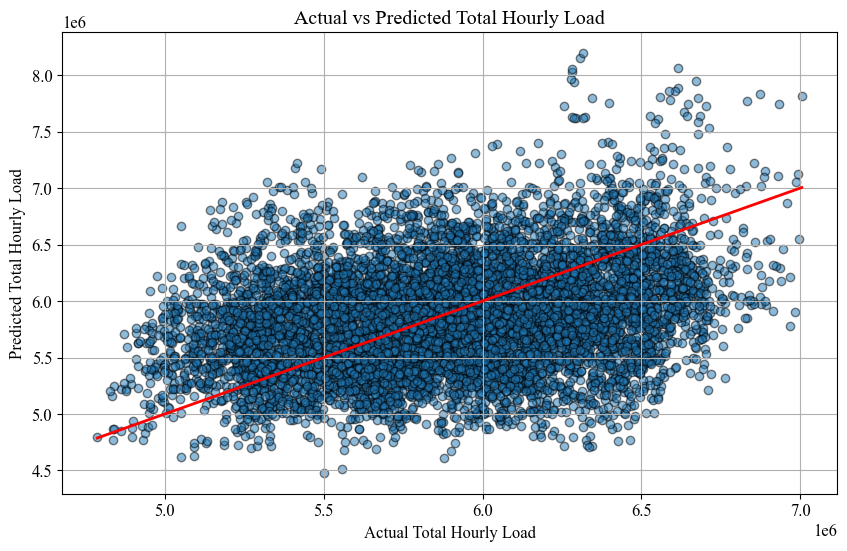

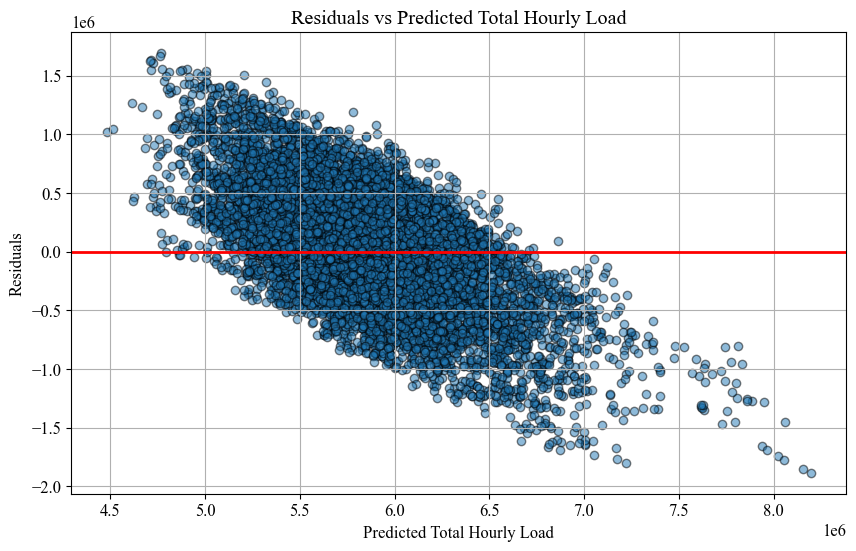

In [ ]:
import matplotlib.pyplot as plt

# Predict the values using the fitted model
y_pred = X @ result.x

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, edgecolor='k')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2)
plt.xlabel('Actual Total Hourly Load')
plt.ylabel('Predicted Total Hourly Load')
plt.title('Actual vs Predicted Total Hourly Load')
plt.grid(True)
plt.show()

# Plotting the residuals
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.axhline(y=0, color='red', linewidth=2)
plt.xlabel('Predicted Total Hourly Load')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Total Hourly Load')
plt.grid(True)
plt.show()